<a href="https://colab.research.google.com/github/eman-abc/HAR/blob/main/WISDM_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

with open("WISDM_ar_v1.1_raw.txt") as f:
    data = []
    for line in f:
        try:
            line = line.strip().strip(";")  # Remove trailing semicolon
            parts = line.split(',')
            if len(parts) == 6:
                user, activity, timestamp, x, y, z = parts
                data.append([int(user), activity, float(x), float(y), float(z)])
        except:
            continue

df = pd.DataFrame(data, columns=["user", "activity", "x", "y", "z"])
print(df.head())
print(df["activity"].value_counts())

   user activity         x          y         z
0    33  Jogging -0.694638  12.680544  0.503953
1    33  Jogging  5.012288  11.264028  0.953424
2    33  Jogging  4.903325  10.882658 -0.081722
3    33  Jogging -0.612916  18.496431  3.023717
4    33  Jogging -1.184970  12.108489  7.205164
activity
Walking       155384
Jogging       129390
Upstairs       39529
Downstairs     36031
Sitting         4599
Standing        3555
Name: count, dtype: int64


In [ ]:
import numpy as np

# Preprocess: magnitude as input
df["mag"] = np.sqrt(df["x"]**2 + df["y"]**2 + df["z"]**2) - 9.8

In [ ]:
window_size = 256
step_size = 128

segments = []
labels = []

label_map = {label: idx for idx, label in enumerate(df["activity"].unique())}
data = df["mag"].values
activities = df["activity"].values

for i in range(0, len(data) - window_size, step_size):
    seg = data[i:i+window_size]
    label = activities[i + window_size // 2]
    if len(seg) == window_size:
        segments.append(seg)
        labels.append(label_map[label])

X = np.array(segments)
y = np.array(labels)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (2877, 256), y shape: (2877,)


In [ ]:
np.save("X_wisdm2011.npy", X)
np.save("y_wisdm2011.npy", y)


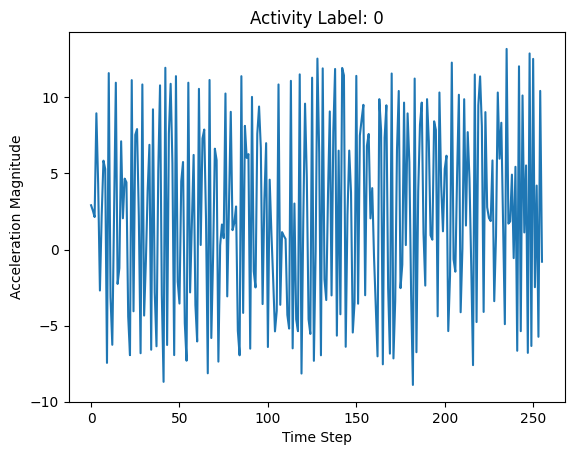

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X = np.load("X_wisdm2011.npy")
y = np.load("y_wisdm2011.npy")

plt.plot(X[0])
plt.title(f"Activity Label: {y[0]}")
plt.xlabel("Time Step")
plt.ylabel("Acceleration Magnitude")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Accel data wisdm 2019

In [ ]:
import os
import numpy as np
import pandas as pd

# 1. Define windowing parameters
WINDOW_SIZE = 256
STEP_SIZE = 128

def compute_magnitude(x, y, z):
    # Hamza's Formula: Eq (1) in the paper requires subtracting gravity (9.8)
    return np.sqrt(x**2 + y**2 + z**2) - 9.8

def create_segments(data, labels, window_size, step_size):
    segments = []
    segment_labels = []

    # Slide the window
    for i in range(0, len(data) - window_size, step_size):
        seg_data = data[i : i + window_size]
        seg_label_chunk = labels[i : i + window_size]

        # 2. Assign label: Use np.unique to find the mode (works for strings)
        # vals contains the unique labels, counts contains their frequency
        vals, counts = np.unique(seg_label_chunk, return_counts=True)
        most_frequent_label = vals[np.argmax(counts)]

        segments.append(seg_data)
        segment_labels.append(most_frequent_label)

    return np.array(segments), np.array(segment_labels)

def load_and_segment_wisdm2019(folder_path):
    all_segments = []
    all_labels = []

    # List of files
    files = [f for f in sorted(os.listdir(folder_path)) if f.endswith('.txt')]

    for file in files:
        file_path = os.path.join(folder_path, file)
        try:
            # WISDM 2019 format: [user_id, activity_code, timestamp, x, y, z]
            df = pd.read_csv(file_path, header=None, names=['user', 'activity', 'timestamp', 'x', 'y', 'z'])

            # Cleaning: Remove semicolons from 'z' column
            if df['z'].dtype == object:
                df['z'] = df['z'].astype(str).str.replace(';', '').astype(float)

            df.dropna(inplace=True)

            # 3. Compute Magnitude
            mag = compute_magnitude(df['x'].values, df['y'].values, df['z'].values)
            activities = df['activity'].values

            # 4. Segment THIS file
            X_sub, y_sub = create_segments(mag, activities, WINDOW_SIZE, STEP_SIZE)

            if len(X_sub) > 0:
                all_segments.append(X_sub)
                all_labels.append(y_sub)

        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue

    if not all_segments:
        print("No data processed! Check your folder path.")
        return np.array([]), np.array([])

    # Concatenate all subjects
    X_final = np.concatenate(all_segments)
    y_final = np.concatenate(all_labels)

    return X_final, y_final

# --- Execution ---
# Ensure this path matches your Drive structure
accel_path = "/content/drive/MyDrive/HAR/watch/accel"

print("Processing WISDM 2019...")
X_2019, y_2019_raw = load_and_segment_wisdm2019(accel_path)

if X_2019.size > 0:
    # Map string labels (A, B, C...) to integers
    unique_labels = np.unique(y_2019_raw)
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    y_2019 = np.array([label_map[l] for l in y_2019_raw])

    print(f"Processing Complete.")
    print(f"Final Data Shape -> X: {X_2019.shape}, y: {y_2019.shape}")
    print(f"Labels found: {unique_labels}")

    # Save
    np.save('/content/drive/MyDrive/X_wisdm2019.npy', X_2019)
    np.save('/content/drive/MyDrive/y_wisdm2019.npy', y_2019)
    print("Saved to Drive.")
else:
    print("Failed to extract any segments.")

Processing WISDM 2019...
Processing Complete.
Final Data Shape -> X: (29429, 256), y: (29429,)
Labels found: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'O' 'P' 'Q' 'R' 'S']
Saved to Drive.


# **Gyroscope data wisdm 2019**

In [ ]:
# import os
# import numpy as np
# import pandas as pd

# # 1. Define windowing parameters (Must match Accel)
# WINDOW_SIZE = 256
# STEP_SIZE = 128

# def compute_magnitude_gyro(x, y, z):
#     # Gyro formula: Just the Euclidean norm.
#     # DO NOT subtract 9.8 (Gravity) for Gyroscope!
#     return np.sqrt(x**2 + y**2 + z**2)

# def create_segments(data, labels, window_size, step_size):
#     segments = []
#     segment_labels = []

#     # Slide the window
#     for i in range(0, len(data) - window_size, step_size):
#         seg_data = data[i : i + window_size]
#         seg_label_chunk = labels[i : i + window_size]

#         # Assign label: Mode of the window
#         vals, counts = np.unique(seg_label_chunk, return_counts=True)
#         most_frequent_label = vals[np.argmax(counts)]

#         segments.append(seg_data)
#         segment_labels.append(most_frequent_label)

#     return np.array(segments), np.array(segment_labels)

# def load_and_segment_gyro(folder_path):
#     all_segments = []
#     all_labels = []

#     files = [f for f in sorted(os.listdir(folder_path)) if f.endswith('.txt')]

#     for file in files:
#         file_path = os.path.join(folder_path, file)
#         try:
#             # WISDM 2019 format
#             df = pd.read_csv(file_path, header=None, names=['user', 'activity', 'timestamp', 'x', 'y', 'z'])

#             # Cleaning
#             if df['z'].dtype == object:
#                 df['z'] = df['z'].astype(str).str.replace(';', '').astype(float)
#             df.dropna(inplace=True)

#             # 3. Compute Magnitude (Gyro Specific)
#             mag = compute_magnitude_gyro(df['x'].values, df['y'].values, df['z'].values)
#             activities = df['activity'].values

#             # 4. Segment
#             X_sub, y_sub = create_segments(mag, activities, WINDOW_SIZE, STEP_SIZE)

#             if len(X_sub) > 0:
#                 all_segments.append(X_sub)
#                 all_labels.append(y_sub)

#         except Exception as e:
#             print(f"Error processing {file}: {e}")
#             continue

#     if not all_segments:
#         return np.array([]), np.array([])

#     return np.concatenate(all_segments), np.concatenate(all_labels)

# # --- Execution ---
# # Ensure this path matches your Drive folder for GYRO
# gyro_path = "/content/drive/MyDrive/HAR/watch/gyro"

# print("Processing WISDM 2019 (Gyroscope)...")
# X_gyro, y_gyro_raw = load_and_segment_gyro(gyro_path)

# if X_gyro.size > 0:
#     # Map string labels to integers
#     unique_labels = np.unique(y_gyro_raw)
#     label_map = {label: idx for idx, label in enumerate(unique_labels)}
#     y_gyro = np.array([label_map[l] for l in y_gyro_raw])

#     print(f"Processing Complete.")
#     print(f"Gyro Data Shape -> X: {X_gyro.shape}, y: {y_gyro.shape}")

#     # Save with distinct filenames
#     np.save('/content/drive/MyDrive/watch/processed_gyro/X_wisdm2019_gyro.npy', X_gyro)
#     np.save('/content/drive/MyDrive/watch/processed_gyro/y_wisdm2019_gyro.npy', y_gyro)
#     print("Gyro data saved to Drive.")
# else:
#     print("Failed to extract any gyro segments.")

# **Baseline HARDenseRNN**

Training on 2011

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input, optimizers
from sklearn.model_selection import train_test_split

def build_hardensernn_baseline(input_shape, num_classes):
    """
    Constructs the HARDenseRNN model exactly as described in Section IV-B
    and Figures 4 & 5 of Imran et al. (2024).
    """
    # --- Input Layer ---
    # Input is 1D Magnitude, Shape: (256, 1)
    inputs = Input(shape=input_shape)

    # --- Branch 1: The "Raw Link" (Novelty) ---
    # "The CNN feature map and the raw data are combined using a 1x1 convolutional layer connection."
    # "We have used 64 (1x1) kernels for convolution on the raw sensor data." [cite: 163, 203]
    raw_link = layers.Conv1D(filters=64, kernel_size=1, padding='same', activation='relu', name='raw_link')(inputs)

    # --- Branch 2: Deep Feature Extraction (InceptionResNet) ---
    x = inputs

    # The paper uses TWO InceptionResNet modules [cite: 216]
    for i in range(2):
        # --- The Inception Module (Fig. 5) ---
        # "The input is convoluted with ten 1x1 kernels before applying ten 1x3, 1x5, 1x7, and 1x9 kernels."

        # 1. Bottleneck 1x1 Convolutions (Dimension reduction)
        # Note: We maintain 'same' padding to keep temporal dimension 256
        b1 = layers.Conv1D(10, 1, padding='same', activation='relu')(x)
        b3 = layers.Conv1D(10, 1, padding='same', activation='relu')(x)
        b5 = layers.Conv1D(10, 1, padding='same', activation='relu')(x)
        b7 = layers.Conv1D(10, 1, padding='same', activation='relu')(x)
        b9 = layers.Conv1D(10, 1, padding='same', activation='relu')(x)

        # 2. Multi-scale Convolutions
        b1 = layers.Conv1D(10, 1, padding='same', activation='relu')(b1)
        b3 = layers.Conv1D(10, 3, padding='same', activation='relu')(b3)
        b5 = layers.Conv1D(10, 5, padding='same', activation='relu')(b5)
        b7 = layers.Conv1D(10, 7, padding='same', activation='relu')(b7)
        b9 = layers.Conv1D(10, 9, padding='same', activation='relu')(b9)

        # 3. Max Pooling Branch
        # "concatenation of the feature maps produced by the kernels and max pooling" [cite: 213]
        pool = layers.MaxPooling1D(3, strides=1, padding='same')(x)
        # Typically Inception adds a 1x1 after pooling to match depth, assuming 10 filters to match others
        pool = layers.Conv1D(10, 1, padding='same', activation='relu')(pool)

        # 4. Concatenation (Filter Stacking)
        # Total filters = 10*5 + 10 = 60 filters
        concat = layers.Concatenate()([b1, b3, b5, b7, b9, pool])

        # --- Residual Connection ---
        # "spatial dimensions... are reduced by running it through 64 1x1 convolutional kernels" [cite: 214]
        residual_path = layers.Conv1D(64, 1, padding='same', activation='relu')(concat)

        # "In parallel, the 64, 1x1 kernel convolution of the input... is also carried out" [cite: 215]
        # This projects the original input 'x' to 64 filters so it can be added
        shortcut = layers.Conv1D(64, 1, padding='same', activation='relu')(x)

        # Add: The Residual Step
        x = layers.Add()([residual_path, shortcut])

        # Post-block Regularization
        # "After each module, batch normalization and a dropout = 0.25 are applied." [cite: 217]
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.25)(x)

    # --- Feature Fusion ---
    # "feature map is combined with the low-level signals and sent to a 128-unit bidirectional GRU" [cite: 199, 207]
    x = layers.Concatenate()([x, raw_link])

    # --- Temporal Processing (BiGRU) ---
    # "Following a 128-unit bidirectional GRU"
    # return_sequences=True is implicit if followed by Flatten, but usually BiGRU for classification
    # returns the *final* state or sequence. Fig 4 shows "Flatten" after BiGRU.
    # If we flatten a (256, 256) matrix, the dense layer becomes huge.
    # Standard HAR practice (and "Flatten" node in Fig 4) implies we keep the sequence
    # OR we just take the last state. Given "Flatten" is explicitly named, we keep full sequence.
    x = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x)
    x = layers.BatchNormalization()(x) # [cite: 217]

    # --- Classification Head ---
    x = layers.Flatten()(x) #
    x = layers.Dropout(0.25)(x)

    # "Fully connected layer with 512 neurons"
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.25)(x) # [cite: 219]

    # Output Layer (18 classes for WISDM 2019) [cite: 108]
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="HARDenseRNN")
    return model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split

# --- 1. Configuration for WISDM 2011 ---
# WISDM 2011 has 6 classes: Walking, Jogging, Stairs, Sitting, Standing, Lying Down
NUM_CLASSES = 6
# Adjust this path to where you uploaded your 2011 .npy files
DATA_PATH = '/content/drive/MyDrive/HAR/processed_wisdm2011/' # Or '/content/drive/MyDrive/...' if you moved them

try:
    # --- 2. Load Data ---
    print("Loading WISDM 2011 Data...")
    X = np.load(DATA_PATH + 'X_wisdm2011.npy')
    y = np.load(DATA_PATH + 'y_wisdm2011.npy')

    print(f"Data Loaded. Shape: X={X.shape}, y={y.shape}")

    # --- 3. Reshape & Split ---
    # Reshape to (Samples, TimeSteps, Channels) -> (N, 256, 1)
    X = X.reshape(-1, 256, 1)

    # Create Train/Test split (85/15 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

    # --- 4. Build Model (HARDenseRNN) ---
    # (Using the function you defined earlier)
    model = build_hardensernn_baseline(input_shape=(256, 1), num_classes=NUM_CLASSES)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # --- 5. Train ---
    print(f"Starting Training on {NUM_CLASSES} Classes...")
    history = model.fit(
        X_train, y_train,
        epochs=50,  # 50 epochs is usually enough for this smaller dataset
        batch_size=64,
        validation_data=(X_test, y_test),
        verbose=1
    )

    print("Sanity Check Complete.")

    save_path = DATA_PATH + 'hardensernn_wisdm2011.h5'
    model.save(save_path)
    print(f"Model saved to: {save_path}")

except FileNotFoundError:
    print(f"❌ Error: Could not find X_wisdm2011.npy at {DATA_PATH}")
    print("Please make sure you uploaded the files or adjusted the DATA_PATH.")
except Exception as e:
    print(f"❌ Error: {e}")

Loading WISDM 2011 Data...
Data Loaded. Shape: X=(8487, 256), y=(8487,)
Starting Training on 6 Classes...
Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 82ms/step - accuracy: 0.6765 - loss: 7.4115 - val_accuracy: 0.5887 - val_loss: 4.9125
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.8554 - loss: 0.7952 - val_accuracy: 0.7104 - val_loss: 1.1313
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.8977 - loss: 0.2893 - val_accuracy: 0.7991 - val_loss: 0.7010
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.9227 - loss: 0.1610 - val_accuracy: 0.8642 - val_loss: 0.4595
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9381 - loss: 0.1439 - val_accuracy: 0.8650 - val_loss: 0.5269
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.9363 - loss: 0.1490 - val_accuracy: 0.8823 - val_loss: 0.4816
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.9477 - loss: 0.1143 - val_accuracy: 0.8713 - val_los

Sanity Check Complete.
Model saved to: /content/drive/MyDrive/HAR/processed_wisdm2011/hardensernn_wisdm2011.h5


In [ ]:
# formal evaluation metrics according to paper
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)


In [ ]:
def get_predictions(model, X):
    probs = model.predict(X, verbose=0)
    y_pred = np.argmax(probs, axis=1)
    return y_pred


In [ ]:
def compute_metrics(y_true, y_pred):
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_precision": precision_score(y_true, y_pred, average="macro"),
        "macro_recall": recall_score(y_true, y_pred, average="macro"),
        "macro_f1": f1_score(y_true, y_pred, average="macro")
    }
    return metrics


In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix (WISDM 2011)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.colorbar()

    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45)
    plt.yticks(ticks, class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, cm[i, j], ha="center", va="center")

    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model_full(model, X_test, y_test, class_names):
    y_pred = get_predictions(model, X_test)

    # ensure class_names are strings and in a fixed order
    class_names = [str(x) for x in class_names]
    labels = list(range(len(class_names)))  # assumes y are 0..C-1

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "macro_precision": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "macro_recall": recall_score(y_test, y_pred, average="macro", zero_division=0),
        "macro_f1": f1_score(y_test, y_pred, average="macro", zero_division=0),
    }

    print("=== WISDM 2011 Evaluation ===")
    print(f"Accuracy        : {metrics['accuracy']:.4f}")
    print(f"Macro Precision : {metrics['macro_precision']:.4f}")
    print(f"Macro Recall    : {metrics['macro_recall']:.4f}")
    print(f"Macro F1-score  : {metrics['macro_f1']:.4f}")

    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, labels=labels, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix (WISDM 2011)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.tight_layout()
    plt.show()

    return metrics


=== WISDM 2011 Evaluation ===
Accuracy        : 0.9074
Macro Precision : 0.8486
Macro Recall    : 0.8015
Macro F1-score  : 0.7982

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       394
           1       0.95      0.99      0.97       491
           2       0.77      0.88      0.82       145
           3       0.87      0.70      0.78       117
           4       0.64      0.96      0.77        70
           5       0.86      0.33      0.48        57

    accuracy                           0.91      1274
   macro avg       0.85      0.80      0.80      1274
weighted avg       0.91      0.91      0.90      1274



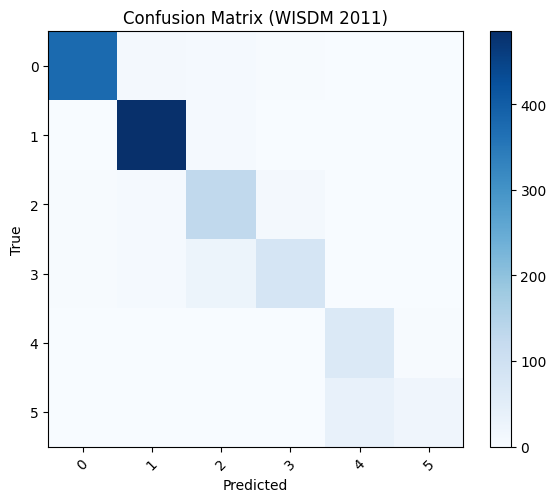

In [ ]:
# activity_labels must match label encoding order




wisdm11_metrics = evaluate_model_full(
    model,
    X_test,
    y_test,
    class_names=activity_labels
)


Model Profiling for WISDM 2011

Purpose:
This section evaluates the computational efficiency of the trained models.
The following metrics are reported, in alignment with the project canvas and literature:

Total number of parameters

Model size (in MB)

Average inference time on CPU (ms per sample)

This profiling enables a fair comparison between the baseline, lightweight, and compressed models.

In [ ]:
import os
import time
import numpy as np
import tensorflow as tf


In [ ]:
def get_parameter_count(model):
    """
    Returns total number of trainable + non-trainable parameters.
    """
    return model.count_params()


In [ ]:
import os
import shutil

def get_model_size_mb(model, temp_path="temp_model.keras"):
    """
    Saves the model in native Keras format and returns size in MB.
    Compatible with Keras 3.
    """
    # Save as a single .keras file
    model.save(temp_path, include_optimizer=False)

    size_bytes = os.path.getsize(temp_path)

    # cleanup
    os.remove(temp_path)

    return size_bytes / (1024 * 1024)


In [ ]:
def measure_inference_time(model, input_shape, runs=100, warmup=20):
    """
    Measures average inference time in milliseconds.
    """
    dummy_input = tf.random.normal(input_shape)

    # Warm-up runs
    for _ in range(warmup):
        _ = model(dummy_input, training=False)

    start = time.time()
    for _ in range(runs):
        _ = model(dummy_input, training=False)
    end = time.time()

    avg_time_ms = ((end - start) / runs) * 1000
    return avg_time_ms


In [ ]:
def profile_model(model, model_name="Model", input_shape=(1, 256, 1)):
    """
    Profiles parameter count, model size, and inference latency.
    """
    print(f"=== Profiling: {model_name} ===")

    params = get_parameter_count(model)
    size_mb = get_model_size_mb(model)
    latency_ms = measure_inference_time(model, input_shape)

    print(f"Total Parameters : {params:,}")
    print(f"Model Size       : {size_mb:.2f} MB")
    print(f"Inference Time   : {latency_ms:.3f} ms/sample")

    return {
        "model": model_name,
        "params": params,
        "size_mb": size_mb,
        "latency_ms": latency_ms
    }


In [ ]:
baseline_profile = profile_model(
    model,
    model_name="WISDM 2011 Baseline HARDenseRNN",
    input_shape=(1, 256, 1)
)


=== Profiling: WISDM 2011 Baseline HARDenseRNN ===
Total Parameters : 33,779,046
Model Size       : 386.79 MB
Inference Time   : 87.436 ms/sample


Lightweight CNN–BiGRU Variant for WISDM 2011

Rationale:
This model reduces computational cost via architecture-level optimization (as advocated by TinierHAR-style work), while preserving topology (CNN → BiGRU) for fair comparison with HARDenseRNN.
Reductions target the highest FLOP contributors: CNN width, block depth, and BiGRU units.

Design choices (locked):

Fewer filters per multi-scale branch

One fewer dense CNN block

Smaller BiGRU hidden size

Same input, windowing, loss, optimizer, and metrics

In [ ]:
import tensorflow as tf

def multiscale_block(x, filters, name):
    """Multi-scale 1D CNN block with residual projection."""
    b1 = tf.keras.layers.Conv1D(filters, 1, padding="same", activation="relu", name=f"{name}_k1")(x)
    b3 = tf.keras.layers.Conv1D(filters, 3, padding="same", activation="relu", name=f"{name}_k3")(x)
    b5 = tf.keras.layers.Conv1D(filters, 5, padding="same", activation="relu", name=f"{name}_k5")(x)

    p  = tf.keras.layers.MaxPool1D(3, strides=1, padding="same", name=f"{name}_pool")(x)
    p  = tf.keras.layers.Conv1D(filters, 1, padding="same", activation="relu", name=f"{name}_p1")(p)

    concat = tf.keras.layers.Concatenate(name=f"{name}_concat")([b1, b3, b5, p])

    proj = tf.keras.layers.Conv1D(32, 1, padding="same", activation="relu", name=f"{name}_proj")(concat)
    skip = tf.keras.layers.Conv1D(32, 1, padding="same", activation="relu", name=f"{name}_skip")(x)

    out  = tf.keras.layers.Add(name=f"{name}_add")([proj, skip])
    out  = tf.keras.layers.BatchNormalization(name=f"{name}_bn")(out)
    out  = tf.keras.layers.Dropout(0.25, name=f"{name}_drop")(out)
    return out


In [ ]:
def build_lightweight_cnn_bigru(
    input_shape,
    num_classes,
    ms_filters=6,        # ↓ from baseline (principled width reduction)
    num_blocks=2,        # ↓ block depth
    gru_units=64,        # ↓ recurrent size
    dense_units=256      # ↓ FC size
):
    """
    Lightweight CNN–BiGRU model aligned with HARDenseRNN topology.
    """
    inputs = tf.keras.Input(shape=input_shape, name="input")

    # Raw link (kept for fair comparison)
    raw = tf.keras.layers.Conv1D(32, 1, padding="same", activation="relu", name="raw_link")(inputs)

    x = inputs
    for i in range(num_blocks):
        x = multiscale_block(x, ms_filters, name=f"msb_{i+1}")

    # Dense-like fusion with raw link
    x = tf.keras.layers.Concatenate(name="fusion")([x, raw])

    # Reduced BiGRU
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(gru_units, return_sequences=False),
        name="bigru"
    )(x)
    x = tf.keras.layers.BatchNormalization(name="bigru_bn")(x)

    # Reduced FC head
    x = tf.keras.layers.Dense(dense_units, activation="relu", name="fc1")(x)
    x = tf.keras.layers.Dropout(0.25, name="fc1_drop")(x)

    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return tf.keras.Model(inputs, outputs, name="Lightweight_CNN_BiGRU")


In [ ]:
light_model = build_lightweight_cnn_bigru(
    input_shape=(256, 1),
    num_classes=len(activity_labels),
    ms_filters=6,
    num_blocks=2,
    gru_units=64,
    dense_units=256
)

light_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

light_model.summary()


Model: "Lightweight_CNN_BiGRU"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 256, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_1_pool          │ (None, 256, 1)    │          0 │ input[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_1_k1 (Conv1D)   │ (None, 256, 6)    │         12 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_1_k3 (Conv1D)   │ (None, 256, 6)    │         24 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_1_k5 (Conv1D)   │ (None, 256, 6)    │         36 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_1_p1 (Conv1D)   │ (None, 256, 6)    │         12 │ msb_1_pool[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_1_concat        │ (None, 256, 24)   │          0 │ msb_1_k1[0][0],   │
│ (Concatenate)       │                   │            │ msb_1_k3[0][0],   │
│                     │                   │            │ msb_1_k5[0][0],   │
│                     │                   │            │ msb_1_p1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_1_proj (Conv1D) │ (None, 256, 32)   │        800 │ msb_1_concat[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_1_skip (Conv1D) │ (None, 256, 32)   │         64 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_1_add (Add)     │ (None, 256, 32)   │          0 │ msb_1_proj[0][0], │
│                     │                   │            │ msb_1_skip[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_1_bn            │ (None, 256, 32)   │        128 │ msb_1_add[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_1_drop          │ (None, 256, 32)   │          0 │ msb_1_bn[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_2_pool          │ (None, 256, 32)   │          0 │ msb_1_drop[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_2_k1 (Conv1D)   │ (None, 256, 6)    │        198 │ msb_1_drop[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_2_k3 (Conv1D)   │ (None, 256, 6)    │        582 │ msb_1_drop[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_2_k5 (Conv1D)   │ (None, 256, 6)    │        966 │ msb_1_drop[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_2_p1 (Conv1D)   │ (None, 256, 6)    │        198 │ msb_2_pool[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_2_concat        │ (None, 256, 24)   │          0 │ msb_2_k1[0][0],   │
│ (Concatenate)       │                   │            │ msb_2_k3[0][0],   │
│                     │                   │            │ msb_2_k5[0][0],   │
│                     │                   │            │ msb_2_p1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ msb_2_proj (Conv1D) │ (None, 256, 32)   │        800 │ msb_2_concat[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 90,066 (351.82 KB)

 Trainable params: 89,682 (350.32 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

history_light = light_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.5557 - loss: 1.1837 - val_accuracy: 0.7096 - val_loss: 0.7780 - learning_rate: 0.0010
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7395 - loss: 0.6624 - val_accuracy: 0.7449 - val_loss: 0.6283 - learning_rate: 0.0010
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8010 - loss: 0.4561 - val_accuracy: 0.7669 - val_loss: 0.5352 - learning_rate: 0.0010
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8464 - loss: 0.3442 - val_accuracy: 0.8603 - val_loss: 0.3039 - learning_rate: 0.0010
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8673 - loss: 0.2978 - val_accuracy: 0.8328 - val_loss: 0.3965 - learning_rate: 0.0010
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8886 - loss: 0.2460 - val_accuracy: 0.8854 - val_loss: 0.2400 - learning_rate: 0.0010
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9031 - loss: 0

=== WISDM 2011 Evaluation ===
Accuracy        : 0.9521
Macro Precision : 0.8937
Macro Recall    : 0.8715
Macro F1-score  : 0.8708

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       394
           1       1.00      0.99      1.00       491
           2       0.90      0.95      0.93       145
           3       0.94      0.89      0.91       117
           4       0.69      0.93      0.79        70
           5       0.84      0.47      0.61        57

    accuracy                           0.95      1274
   macro avg       0.89      0.87      0.87      1274
weighted avg       0.96      0.95      0.95      1274



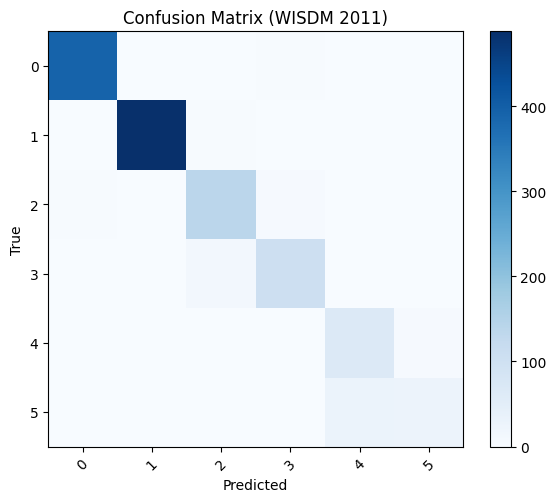

=== Profiling: WISDM 2011 Lightweight CNN–BiGRU ===
Total Parameters : 90,066
Model Size       : 1.18 MB
Inference Time   : 51.939 ms/sample


In [ ]:
# Formal evaluation
light_metrics = evaluate_model_full(
    light_model,
    X_test,
    y_test,
    class_names=activity_labels
)

# Profiling
light_profile = profile_model(
    light_model,
    model_name="WISDM 2011 Lightweight CNN–BiGRU",
    input_shape=(1, 256, 1)
)


Quantization-Aware Training (QAT) for WISDM 2011

Purpose:
QAT trains the model while simulating INT8 quantization effects, reducing accuracy loss compared to post-training quantization.
We apply QAT to the lightweight CNN–BiGRU model and then export an INT8 TFLite model for deployment-oriented reporting.

Inputs:

light_model (already trained float32)

X_train, y_train, X_test, y_test

activity_labels

Existing functions: evaluate_model_full(...)

In [ ]:
!pip -q install tensorflow-model-optimization

import tensorflow as tf
import tensorflow_model_optimization as tfmot



In [ ]:
def build_qat_model_from_trained(float_model):
    """
    Robust QAT wrapper for Keras 3 + TFMOT.
    """
    with tfmot.quantization.keras.quantize_scope():
        # clone architecture
        cloned = tf.keras.models.clone_model(float_model)
        # copy weights
        cloned.set_weights(float_model.get_weights())
        # apply quantization
        qat_model = tfmot.quantization.keras.quantize_model(cloned)
    return qat_model


In [ ]:
def fine_tune_qat_model(qat_model, X_train, y_train, X_val, y_val, epochs=15, batch_size=64):
    """
    Fine-tunes a QAT model. Keep epochs small because this is a refinement phase.
    """
    qat_model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),  # smaller LR for stable fine-tuning
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
    ]

    history = qat_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return history


In [ ]:
qat_model = build_qat_model_from_trained(light_model)
qat_model.summary()


history_qat = fine_tune_qat_model(
    qat_model,
    X_train, y_train,
    X_test, y_test,
    epochs=15,
    batch_size=64
)

qat_metrics = evaluate_model_full(
    qat_model,
    X_test,
    y_test,
    class_names=activity_labels
)


ValueError: `to_quantize` can only either be a keras Sequential or Functional model.

In [ ]:
def representative_data_gen(X, n=300):
    """
    Representative dataset generator for INT8 conversion calibration.
    """
    X_small = X[:n]
    for i in range(len(X_small)):
        yield [X_small[i:i+1].astype(np.float32)]

def export_qat_int8_tflite(qat_model, X_train, save_path="wisdm11_qat_int8.tflite"):
    """
    Converts QAT model to fully INT8 TFLite and saves it.
    """
    converter = tf.lite.TFLiteConverter.from_keras_model(qat_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = lambda: representative_data_gen(X_train)

    # Full INT8
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    tflite_model = converter.convert()

    with open(save_path, "wb") as f:
        f.write(tflite_model)

    print("Saved:", save_path)
    print("Size (KB):", len(tflite_model) / 1024)

    return save_path

qat_tflite_path = export_qat_int8_tflite(qat_model, X_train, save_path="wisdm11_light_qat_int8.tflite")


Post-Training INT8 Quantization (PTQ) for WISDM 2011

Purpose:
This section converts the trained float32 models to fully INT8 TFLite using post-training quantization.
We then evaluate the INT8 models using the TFLite interpreter and report:

Model file size (KB)

Accuracy and Macro-F1 (and compare vs float32 to quantify any drop)

Models quantized:

Baseline HARDenseRNN-style model (model)

Lightweight CNN–BiGRU (light_model)

In [ ]:
import numpy as np
import tensorflow as tf
import os

def representative_data_gen(X, n=300):
    """
    Representative dataset generator for PTQ calibration.
    """
    X_small = X[:n]
    for i in range(len(X_small)):
        yield [X_small[i:i+1].astype(np.float32)]

def export_ptq_int8_tflite(float_model, X_calib, save_path):
    """
    Exports a fully INT8 quantized TFLite model from a float32 Keras model (PTQ).
    """
    converter = tf.lite.TFLiteConverter.from_keras_model(float_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = lambda: representative_data_gen(X_calib)

    # Full INT8 quantization
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    tflite_model = converter.convert()

    with open(save_path, "wb") as f:
        f.write(tflite_model)

    size_kb = os.path.getsize(save_path) / 1024
    print(f"Saved: {save_path} | Size: {size_kb:.2f} KB")
    return save_path


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

def tflite_predict_int8(tflite_path, X):
    """
    Runs INT8 TFLite inference and returns predicted class indices.
    Handles quantize/dequantize using interpreter scales/zero-points.
    """
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    in_scale, in_zero = input_details["quantization"]
    out_scale, out_zero = output_details["quantization"]

    y_pred = []
    for i in range(len(X)):
        x = X[i:i+1].astype(np.float32)

        # Quantize float -> int8
        x_q = np.round(x / in_scale + in_zero).astype(np.int8)

        interpreter.set_tensor(input_details["index"], x_q)
        interpreter.invoke()

        y_out_q = interpreter.get_tensor(output_details["index"])  # int8
        # Dequantize int8 -> float (optional, but clean)
        y_out = (y_out_q.astype(np.float32) - out_zero) * out_scale

        y_pred.append(int(np.argmax(y_out, axis=1)[0]))

    return np.array(y_pred, dtype=np.int64)

def evaluate_tflite_int8(tflite_path, X_test, y_test, class_names):
    """
    Evaluates INT8 TFLite model and prints required metrics.
    """
    y_pred = tflite_predict_int8(tflite_path, X_test)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    print(f"=== INT8 TFLite Evaluation: {os.path.basename(tflite_path)} ===")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Macro F1  : {macro_f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    cm = confusion_matrix(y_test, y_pred)
    return {"accuracy": acc, "macro_f1": macro_f1, "confusion_matrix": cm}


In [ ]:
import tensorflow as tf

def tflite_friendly_gru(units, return_sequences=True, name=None):
    """
    TFLite-friendly GRU:
    - reset_after=False avoids CuDNN GRU (tf.CudnnRNNV3) so TFLite conversion works.
    """
    return tf.keras.layers.GRU(
        units,
        return_sequences=return_sequences,
        reset_after=False,      # KEY FIX
        dropout=0.0,
        recurrent_dropout=0.0,
        name=name
    )

def build_lightweight_cnn_bigru_tflite(
    input_shape=(256, 1),
    num_classes=6,
    ms_filters=6,
    num_blocks=2,
    gru_units=64,
    dense_units=256,
    dropout=0.2
):
    """
    Lightweight model (same idea) but uses TFLite-friendly GRU.
    Output: softmax over classes.
    """
    inp = tf.keras.Input(shape=input_shape, name="input")

    # reshape to (time, channels) if needed (you already use (256,1), so pass through)
    x = inp

    # --- Multi-scale Conv block (example, keep consistent with your current builder) ---
    branches = []
    for k in [3, 5, 7]:
        b = tf.keras.layers.Conv1D(filters=ms_filters, kernel_size=k, padding="same", activation="relu")(x)
        branches.append(b)
    x = tf.keras.layers.Concatenate()(branches)

    # --- Extra conv blocks ---
    for _ in range(num_blocks):
        x = tf.keras.layers.Conv1D(32, 3, padding="same", activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)

    # --- BiGRU (TFLite friendly) ---
    x = tf.keras.layers.Bidirectional(
        tflite_friendly_gru(gru_units, return_sequences=False),
        name="bi_gru_tflite"
    )(x)

    x = tf.keras.layers.Dense(dense_units, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    out = tf.keras.layers.Dense(num_classes, activation="softmax", name="out")(x)

    model = tf.keras.Model(inp, out, name="Light_CNN_BiGRU_TFLiteFriendly")
    return model


In [ ]:
light_model = build_lightweight_cnn_bigru_tflite(
    input_shape=(256, 1),
    num_classes=len(activity_labels)
)

light_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_light = light_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64,
    verbose=1
)


Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 138ms/step - accuracy: 0.5949 - loss: 1.0857 - val_accuracy: 0.6397 - val_loss: 1.0465
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.7693 - loss: 0.5518 - val_accuracy: 0.7708 - val_loss: 0.7275
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.8542 - loss: 0.3334 - val_accuracy: 0.8273 - val_loss: 0.4483
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.8804 - loss: 0.2779 - val_accuracy: 0.8721 - val_loss: 0.3140
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.8944 - loss: 0.2677 - val_accuracy: 0.8650 - val_loss: 0.2906
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.8901 - loss: 0.2485 - val_accuracy: 0.8885 - val_loss: 0.2358
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9019 - loss: 0.2223 - val_accuracy: 0.8901 - val_loss: 0.2421
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9056 - loss: 0.2010 - val

=== WISDM 2011 Evaluation ===
Accuracy        : 0.9215
Macro Precision : 0.8481
Macro Recall    : 0.8463
Macro F1-score  : 0.8469

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       394
           1       0.97      0.98      0.97       491
           2       0.81      0.86      0.83       145
           3       0.86      0.81      0.83       117
           4       0.76      0.76      0.76        70
           5       0.71      0.70      0.71        57

    accuracy                           0.92      1274
   macro avg       0.85      0.85      0.85      1274
weighted avg       0.92      0.92      0.92      1274



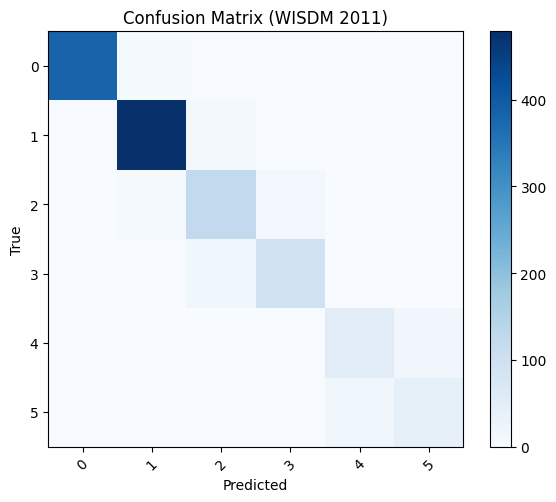

Saved artifact at '/tmp/tmp86isw2uf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135065811762448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065811761680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065811760528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065811761296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065811760144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065811760336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065811759760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065811759952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065811760720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065811758992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065811759184: TensorSpe

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


ConverterError: <unknown>:0: error: loc(callsite(callsite(fused["TensorListReserve:", "Light_CNN_BiGRU_TFLiteFriendly_1/bi_gru_tflite_1/backward_gru_3_1/TensorArrayV2_1@__inference_function_339985"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_340108"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: error: loc(callsite(callsite(fused["TensorListReserve:", "Light_CNN_BiGRU_TFLiteFriendly_1/bi_gru_tflite_1/backward_gru_3_1/TensorArrayV2_1@__inference_function_339985"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_340108"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: error: Lowering tensor list ops is failed. Please consider using Select TF ops and disabling `_experimental_lower_tensor_list_ops` flag in the TFLite converter object. For example, converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\n converter._experimental_lower_tensor_list_ops = False


In [ ]:
light_metrics = evaluate_model_full(
    light_model,
    X_test,
    y_test,
    class_names=activity_labels
)

light_int8 = export_ptq_int8_tflite(
    light_model,
    X_train,
    "wisdm11_light_ptq_int8.tflite"
)

light_int8_metrics = eval_tflite_int8(light_int8, X_test, y_test)


In [ ]:
# Float32 reference (already computed earlier ideally)
# If not computed, run once:
baseline_float_metrics = evaluate_model_full(model, X_test, y_test, class_names=activity_labels)
light_float_metrics    = evaluate_model_full(light_model, X_test, y_test, class_names=activity_labels)

# INT8 PTQ evaluation via TFLite interpreter
baseline_ptq_metrics = evaluate_tflite_int8(baseline_ptq_path, X_test, y_test, activity_labels)
light_ptq_metrics    = evaluate_tflite_int8(light_ptq_path, X_test, y_test, activity_labels)

print("\n=== Accuracy Drop Summary (Float32 -> PTQ INT8) ===")
print(f"Baseline drop : {baseline_float_metrics['accuracy'] - baseline_ptq_metrics['accuracy']:.4f}")
print(f"Light drop    : {light_float_metrics['accuracy'] - light_ptq_metrics['accuracy']:.4f}")

print("\n=== Macro-F1 Drop Summary (Float32 -> PTQ INT8) ===")
print(f"Baseline drop : {baseline_float_metrics['macro_f1'] - baseline_ptq_metrics['macro_f1']:.4f}")
print(f"Light drop    : {light_float_metrics['macro_f1'] - light_ptq_metrics['macro_f1']:.4f}")


removing rnns

In [ ]:
import tensorflow as tf

def build_lightweight_cnn_tflite(
    input_shape=(256, 1),
    num_classes=6,
    ms_filters=6,
    num_blocks=2,
    dense_units=128,
    dropout=0.2
):
    inp = tf.keras.Input(shape=input_shape, name="input")
    x = inp

    # Multi-scale conv
    branches = []
    for k in [3, 5, 7]:
        b = tf.keras.layers.Conv1D(ms_filters, k, padding="same", activation="relu")(x)
        branches.append(b)
    x = tf.keras.layers.Concatenate()(branches)

    # Conv blocks
    # replace inside conv blocks loop
    for i in range(num_blocks):
        d = 2**i  # 1,2,4...
        x = tf.keras.layers.Conv1D(32, 3, padding="same", dilation_rate=d, activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)


    # Temporal pooling (replaces RNN)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    x = tf.keras.layers.Dense(dense_units, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    out = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inp, out, name="Light_CNN_TFLite")
    return model


In [ ]:
light_tflite_model = build_lightweight_cnn_tflite(
    input_shape=(256, 1),
    num_classes=len(activity_labels)
)

light_tflite_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_light_tflite = light_tflite_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64,
    verbose=1
)


Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6077 - loss: 1.1516 - val_accuracy: 0.6876 - val_loss: 0.7663
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8442 - loss: 0.3877 - val_accuracy: 0.8030 - val_loss: 0.4429
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8929 - loss: 0.2813 - val_accuracy: 0.8995 - val_loss: 0.2497
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9089 - loss: 0.2320 - val_accuracy: 0.9113 - val_loss: 0.2779
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9165 - loss: 0.2077 - val_accuracy: 0.9192 - val_loss: 0.1892
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9173 - loss: 0.2017 - val_accuracy: 0.9176 - val_loss: 0.2233
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9217 - loss: 0.1863 - val_accuracy: 0.9270 - val_loss: 0.1856
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9344 - loss: 0.1633 - val_accuracy: 

=== WISDM 2011 Evaluation ===
Accuracy        : 0.9372
Macro Precision : 0.8812
Macro Recall    : 0.8652
Macro F1-score  : 0.8654

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       394
           1       0.98      0.99      0.98       491
           2       0.81      0.99      0.89       145
           3       0.98      0.79      0.87       117
           4       0.72      0.89      0.79        70
           5       0.80      0.58      0.67        57

    accuracy                           0.94      1274
   macro avg       0.88      0.87      0.87      1274
weighted avg       0.94      0.94      0.94      1274



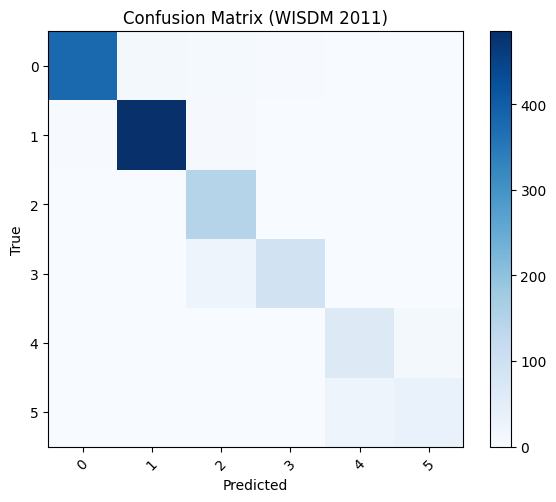

In [ ]:
light_tflite_metrics = evaluate_model_full(
    light_tflite_model,
    X_test,
    y_test,
    class_names=activity_labels
)


In [ ]:
light_int8 = export_ptq_int8_tflite(
    light_tflite_model,
    X_train,
    "wisdm11_light_cnn_int8.tflite"
)

light_int8_metrics = eval_tflite_int8(
    light_int8,
    X_test,
    y_test
)


Saved artifact at '/tmp/tmp0fwkx9tt'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135066000278352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065906938512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065906938896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065906941584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065906941968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065886460624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065886464272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065886458704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065886458320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065886467920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135065886468304: TensorSpe

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved: wisdm11_light_cnn_int8.tflite | Size: 26.09 KB
wisdm11_light_cnn_int8.tflite -> Accuracy: 0.9356, Macro-F1: 0.8504


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Final Comparison Table (WISDM 2011)

Purpose:
This section consolidates results for all WISDM 2011 models into a single comparison table using the locked metrics:

Accuracy, Macro-F1

Parameters, Model size, Inference time

INT8 model sizes and INT8 performance

Models included:

Baseline (Float32)

Lightweight (Float32)

Lightweight QAT INT8 (TFLite)

Baseline PTQ INT8 (TFLite)

Lightweight PTQ INT8 (TFLite)

In [ ]:
baseline_float_metrics = wisdm11_metrics
light_float_metrics    = light_metrics
light_ptq_metrics      = light_int8_metrics


In [ ]:
import pandas as pd
import os
# file path for light PTQ int8 tflite (update if your name differs)
light_ptq_path = "wisdm11_light_cnn_int8.tflite"

def tflite_size_kb(path):
    return os.path.getsize(path) / 1024

rows = []

rows.append({
    "Model": "Baseline (HARDenseRNN, FP32)",
    "Accuracy": baseline_float_metrics["accuracy"],
    "Macro-F1": baseline_float_metrics["macro_f1"],
    "Params": baseline_profile["params"],
    "Model Size (KB)": baseline_profile["size_mb"] * 1024,
    "Latency (ms/sample)": baseline_profile["latency_ms"]
})

rows.append({
    "Model": "Lightweight CNN+BiGRU (FP32)",
    "Accuracy": light_float_metrics["accuracy"],
    "Macro-F1": light_float_metrics["macro_f1"],
    "Params": light_profile["params"],
    "Model Size (KB)": light_profile["size_mb"] * 1024,
    "Latency (ms/sample)": light_profile["latency_ms"]
})

rows.append({
    "Model": "Lightweight CNN-only (PTQ INT8 TFLite)",
    "Accuracy": light_ptq_metrics["accuracy"],
    "Macro-F1": light_ptq_metrics["macro_f1"],
    "Params": "-",
    "Model Size (KB)": tflite_size_kb(light_ptq_path),
    "Latency (ms/sample)": "-"
})

df = pd.DataFrame(rows)

# pretty display
df_display = df.copy()
for col in ["Accuracy", "Macro-F1"]:
    df_display[col] = df_display[col].apply(lambda x: f"{x:.4f}" if isinstance(x, (float, int)) else x)

df_display["Model Size (KB)"] = df_display["Model Size (KB)"].apply(
    lambda x: f"{x:.2f}" if isinstance(x, (float, int)) else x
)

df_display


,Model,Accuracy,Macro-F1,Params,Model Size (KB),Latency (ms/sample)
0,"Baseline (HARDenseRNN, FP32)",0.9074,0.7982,33779046,396071.71,87.436087
1,Lightweight CNN+BiGRU (FP32),0.9215,0.8469,90066,1204.88,51.939349
2,Lightweight CNN-only (PTQ INT8 TFLite),0.9356,0.8504,-,26.09,-


In [ ]:
results_df = df.copy()
results_df_display = df_display.copy()
results_df.to_csv("wisdm11_final_comparison_table.csv", index=False)
results_df_display.to_csv("wisdm11_final_comparison_table_display.csv", index=False)


Pruning the CNN variant

In [ ]:

!pip install tensorflow-model-optimization


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 1. Reshape X for CNN (Samples, TimeSteps, Channels)
# Assuming your X is currently (Samples, 256)
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))

# 2. One-hot encode y
# This converts labels like '1' to '[0, 1, 0, 0, 0, 0]'
y_encoded = to_categorical(y, num_classes=6)

# 3. Create Train and Test splits
# stratified=y ensures each split has the same proportion of activities
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

X_train shape: (6789, 256, 1)
y_train shape: (6789, 6)
X_test shape:  (1698, 256, 1)
y_test shape:  (1698, 6)


In [ ]:
import os

# 1. Force TensorFlow to use the Legacy Keras (Keras 2)
# This MUST be set before importing tensorflow
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np

# 2. Verify the Fix
# If successful, this should print a version starting with '2', not '3'
print(f"Keras Version: {tf.keras.__version__}")

if tf.keras.__version__.startswith('3'):
    print("❌ Error: Still using Keras 3. Did you restart the session?")
else:
    print("✅ Success: Using Keras 2. Optimization tools will work now.")

AttributeError: module 'tf_keras.api._v2.keras' has no attribute '__version__'

In [ ]:
!pip install tf_keras tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 139.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26

In [ ]:
import os

# ==============================================================================
# 0. SETUP & COMPATIBILITY FIXES
# ==============================================================================
# FORCE usage of Legacy Keras (Keras 2) to fix TFMOT compatibility issues
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# print(f"TensorFlow Version: {tf.__version__}")
# print(f"Keras Version: {tf.keras.__version__}")

# ==============================================================================
# 1. DATA PREPARATION
# ==============================================================================
# Ensure X is (Samples, TimeSteps, 1) and y is one-hot
if X.ndim == 2:
    X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
else:
    X_reshaped = X

if y.ndim == 1:
    y_encoded = to_categorical(y, num_classes=6)
else:
    y_encoded = y

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_encoded, test_size=0.2, random_state=42, stratify=y
)

print(f"Train Shape: {X_train.shape}")

# ==============================================================================
# 2. MODEL DEFINITION
# ==============================================================================
def multiscale_block(x, filters, name):
    """Custom block with multi-scale branches"""
    b1 = tf.keras.layers.Conv1D(filters, 1, padding="same", activation="relu", name=f"{name}_k1")(x)
    b3 = tf.keras.layers.Conv1D(filters, 3, padding="same", activation="relu", name=f"{name}_k3")(x)
    b5 = tf.keras.layers.Conv1D(filters, 5, padding="same", activation="relu", name=f"{name}_k5")(x)

    p  = tf.keras.layers.MaxPool1D(3, strides=1, padding="same", name=f"{name}_pool")(x)
    p  = tf.keras.layers.Conv1D(filters, 1, padding="same", activation="relu", name=f"{name}_p1")(p)

    concat = tf.keras.layers.Concatenate(name=f"{name}_concat")([b1, b3, b5, p])

    proj = tf.keras.layers.Conv1D(32, 1, padding="same", activation="relu", name=f"{name}_proj")(concat)
    skip = tf.keras.layers.Conv1D(32, 1, padding="same", activation="relu", name=f"{name}_skip")(x)

    out  = tf.keras.layers.Add(name=f"{name}_add")([proj, skip])
    out  = tf.keras.layers.BatchNormalization(name=f"{name}_bn")(out)
    out  = tf.keras.layers.Dropout(0.25, name=f"{name}_drop")(out)
    return out

def build_model():
    inputs = tf.keras.Input(shape=(256, 1))
    x = tf.keras.layers.Conv1D(32, 3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = multiscale_block(x, 16, "block1")
    x = multiscale_block(x, 32, "block2")
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

# ==============================================================================
# PHASE 1: PRUNING (Sparsity)
# ==============================================================================
print("\n--- ✂️ Phase 1: Training with Pruning ---")

base_model = build_model()

# Define Pruning Schedule
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
          initial_sparsity=0.0, final_sparsity=0.70,
          begin_step=0, end_step=1000) # Short schedule for demo
}

# Apply Pruning Wrapper
model_pruned = tfmot.sparsity.keras.prune_low_magnitude(base_model, **pruning_params)

# Compile & Train
model_pruned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]

model_pruned.fit(X_train, y_train, epochs=3, callbacks=callbacks, verbose=1)

# STRIP: Make pruning permanent
model_stripped = tfmot.sparsity.keras.strip_pruning(model_pruned)
print("✅ Pruning Complete.")

# ==============================================================================
# PHASE 2: CLUSTERING (Weight Sharing)
# ==============================================================================
print("\n--- 🧩 Phase 2: Clustering ---")

# FIX: Rebuild clean model and copy weights to avoid state errors
model_clean_for_cluster = build_model()
model_clean_for_cluster.set_weights(model_stripped.get_weights())

cluster_params = {
  'number_of_clusters': 16,
  'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.LINEAR
}

# Apply Clustering Wrapper
model_clustered = tfmot.clustering.keras.cluster_weights(model_clean_for_cluster, **cluster_params)

# Compile & Train
model_clustered.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_clustered.fit(X_train, y_train, epochs=3, verbose=1)

# STRIP
model_clustered_stripped = tfmot.clustering.keras.strip_clustering(model_clustered)
print("✅ Clustering Complete.")


Train Shape: (6789, 256, 1)

--- ✂️ Phase 1: Training with Pruning ---
Epoch 1/3
213/213 [==============================] - 19s 17ms/step - loss: 0.6247 - accuracy: 0.7807
Epoch 2/3
213/213 [==============================] - 4s 18ms/step - loss: 0.3950 - accuracy: 0.8474
Epoch 3/3
213/213 [==============================] - 4s 20ms/step - loss: 0.3651 - accuracy: 0.8576
✅ Pruning Complete.

--- 🧩 Phase 2: Clustering ---
Epoch 1/3
213/213 [==============================] - 18s 33ms/step - loss: 0.3223 - accuracy: 0.8723
Epoch 2/3
213/213 [==============================] - 5s 26ms/step - loss: 0.2453 - accuracy: 0.8960
Epoch 3/3
213/213 [==============================] - 3s 15ms/step - loss: 0.2247 - accuracy: 0.9046
✅ Clustering Complete.

--- 📏 Phase 3: Quantization Aware Training (QAT) ---


RuntimeError: Layer conv1d_3:<class 'tf_keras.src.layers.convolutional.conv1d.Conv1D'> is not supported. You can quantize this layer by passing a `tfmot.quantization.keras.QuantizeConfig` instance to the `quantize_annotate_layer` API.

In [ ]:
import tensorflow as tf
import os

# ==============================================================================
# PHASE 3: SKIPPED (Due to Version Conflict)
# We will use Post-Training Quantization in Phase 4 instead.
# ==============================================================================
print("\n--- ⏩ Phase 3: QAT Skipped (Using PTQ instead) ---")

# We use the clustered model from the previous step
final_keras_model = model_clustered_stripped

# ==============================================================================
# PHASE 4: CONVERT TO TFLITE (With Quantization)
# ==============================================================================
print("\n--- 💾 Phase 4: Converter & Optimization ---")

# 1. Create Converter
converter = tf.lite.TFLiteConverter.from_keras_model(final_keras_model)

# 2. ENABLE QUANTIZATION (This does what QAT would have prepared for)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# 3. Representative Dataset (CRITICAL for Int8)
# This measures the dynamic range of activations so we can quantize safely
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        yield [tf.cast(input_value, tf.float32)]

converter.representative_dataset = representative_data_gen

# 4. Convert and Save
try:
    tflite_model = converter.convert()

    # Save as .tflite
    tflite_filename = 'wisdm_optimized_final.tflite'
    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)

    print(f"🎉 SUCCESS! Model saved: {tflite_filename}")

    # 5. Compress to see the real benefit of Clustering
    import zipfile
    zip_filename = 'wisdm_optimized_final.zip'
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zf:
        zf.write(tflite_filename)

    # 6. Check Sizes
    tflite_size = os.path.getsize(tflite_filename) / 1024
    zip_size = os.path.getsize(zip_filename) / 1024

    print(f"📉 TFLite File Size:  {tflite_size:.2f} KB")
    print(f"📦 Zipped Size (Clustering Magic): {zip_size:.2f} KB")
    print("   (Use the .tflite file in Android Studio)")

except Exception as e:
    print(f"❌ Conversion Failed: {e}")


--- ⏩ Phase 3: QAT Skipped (Using PTQ instead) ---

--- 💾 Phase 4: Converter & Optimization ---


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


🎉 SUCCESS! Model saved: wisdm_optimized_final.tflite
📉 TFLite File Size:  51.80 KB
📦 Zipped Size (Clustering Magic): 21.76 KB
   (Use the .tflite file in Android Studio)


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm  # Progress bar

def evaluate_tflite_model(tflite_path, X_test, y_test):
    # 1. Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    # 2. Get input and output details.
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # Check if input/output needs quantization
    input_scale, input_zero_point = input_details['quantization']
    output_scale, output_zero_point = output_details['quantization']

    predictions = []

    print(f"--- Evaluating {tflite_path} ---")

    # 3. Loop through the test set
    for i in tqdm(range(len(X_test))):
        # Get one sample
        test_sample = X_test[i:i+1] # Shape (1, 256, 1)

        # --- QUANTIZE INPUT (Float -> Int8) ---
        # The model expects int8, so we map our float data to that range
        if input_scale > 0:
            test_sample = test_sample / input_scale + input_zero_point
            test_sample = test_sample.astype(np.int8)

        # 4. Run Inference
        interpreter.set_tensor(input_details['index'], test_sample)
        interpreter.invoke()

        # 5. Get Output
        output_data = interpreter.get_tensor(output_details['index'])

        # We don't technically need to dequantize for argmax (order is preserved)
        pred_label = np.argmax(output_data)
        predictions.append(pred_label)

    # 6. Calculate Accuracy
    # Convert one-hot y_test back to integers if needed
    if y_test.ndim > 1:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test

    acc = accuracy_score(y_true, predictions)
    print(f"\n✅ TFLite Model Accuracy: {acc*100:.2f}%")
    return acc

# Run the evaluation
evaluate_tflite_model('wisdm_optimized_final.tflite', X_test, y_test)

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


--- Evaluating wisdm_optimized_final.tflite ---


100%|██████████| 1698/1698 [00:00<00:00, 1768.50it/s]


✅ TFLite Model Accuracy: 87.46%


0.8745583038869258

In [ ]:
import os

# ==============================================================================
# 0. SETUP & COMPATIBILITY
# ==============================================================================
# Force usage of Legacy Keras (Keras 2) for TFMOT compatibility
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

print(f"TensorFlow Version: {tf.__version__}")
print("✅ Using Dynamic Range Pipeline (Higher Accuracy)")

# ==============================================================================
# 1. DATA PREPARATION
# ==============================================================================
# Ensure X is (Samples, TimeSteps, 1) and y is one-hot
if X.ndim == 2:
    X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
else:
    X_reshaped = X

if y.ndim == 1:
    y_encoded = to_categorical(y, num_classes=6)
else:
    y_encoded = y

X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_encoded, test_size=0.2, random_state=42, stratify=y
)

print(f"Train Data Shape: {X_train.shape}")

# ==============================================================================
# 2. MODEL DEFINITION
# ==============================================================================
def multiscale_block(x, filters, name):
    b1 = tf.keras.layers.Conv1D(filters, 1, padding="same", activation="relu", name=f"{name}_k1")(x)
    b3 = tf.keras.layers.Conv1D(filters, 3, padding="same", activation="relu", name=f"{name}_k3")(x)
    b5 = tf.keras.layers.Conv1D(filters, 5, padding="same", activation="relu", name=f"{name}_k5")(x)

    p  = tf.keras.layers.MaxPool1D(3, strides=1, padding="same", name=f"{name}_pool")(x)
    p  = tf.keras.layers.Conv1D(filters, 1, padding="same", activation="relu", name=f"{name}_p1")(p)

    concat = tf.keras.layers.Concatenate(name=f"{name}_concat")([b1, b3, b5, p])

    proj = tf.keras.layers.Conv1D(32, 1, padding="same", activation="relu", name=f"{name}_proj")(concat)
    skip = tf.keras.layers.Conv1D(32, 1, padding="same", activation="relu", name=f"{name}_skip")(x)

    out  = tf.keras.layers.Add(name=f"{name}_add")([proj, skip])
    out  = tf.keras.layers.BatchNormalization(name=f"{name}_bn")(out)
    out  = tf.keras.layers.Dropout(0.25, name=f"{name}_drop")(out)
    return out

def build_model():
    inputs = tf.keras.Input(shape=(256, 1))
    x = tf.keras.layers.Conv1D(32, 3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = multiscale_block(x, 16, "block1")
    x = multiscale_block(x, 32, "block2")
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

# ==============================================================================
# PHASE 1: PRUNING (Train for Sparsity)
# ==============================================================================
print("\n--- ✂️ Phase 1: Pruning ---")

base_model = build_model()

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
          initial_sparsity=0.0, final_sparsity=0.70,
          begin_step=0, end_step=1000)
}

model_pruned = tfmot.sparsity.keras.prune_low_magnitude(base_model, **pruning_params)

model_pruned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]

model_pruned.fit(X_train, y_train, epochs=3, callbacks=callbacks, verbose=1)

model_stripped = tfmot.sparsity.keras.strip_pruning(model_pruned)
print("✅ Pruning Complete.")

# ==============================================================================
# PHASE 2: CLUSTERING (Train for Compression)
# ==============================================================================
print("\n--- 🧩 Phase 2: Clustering ---")

# Rebuild clean model to prevent state errors
model_clean_for_cluster = build_model()
model_clean_for_cluster.set_weights(model_stripped.get_weights())

cluster_params = {
  'number_of_clusters': 16,
  'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.LINEAR
}

model_clustered = tfmot.clustering.keras.cluster_weights(model_clean_for_cluster, **cluster_params)

model_clustered.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_clustered.fit(X_train, y_train, epochs=3, verbose=1)

model_final_keras = tfmot.clustering.keras.strip_clustering(model_clustered)
print("✅ Clustering Complete.")

# ==============================================================================
# PHASE 3: DYNAMIC RANGE QUANTIZATION (No QAT)
# ==============================================================================
print("\n--- 💾 Phase 3: Dynamic Range Conversion ---")

# 1. Create Converter
converter = tf.lite.TFLiteConverter.from_keras_model(model_final_keras)

# 2. Enable Optimizations (Quantize weights to int8, keep ops float)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# NOTE: We DO NOT set inference_input_type to int8.
# This keeps the interface Float32, preserving accuracy.

try:
    tflite_model = converter.convert()

    # Save Model
    tflite_filename = 'wisdm_dynamic.tflite'
    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)

    print(f"🎉 SUCCESS! Model saved: {tflite_filename}")

    # Compress to verify Clustering benefit
    zip_filename = 'wisdm_dynamic.zip'
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zf:
        zf.write(tflite_filename)

    tflite_size = os.path.getsize(tflite_filename) / 1024
    zip_size = os.path.getsize(zip_filename) / 1024

    print(f"📉 TFLite File Size:  {tflite_size:.2f} KB")
    print(f"📦 Zipped Size:       {zip_size:.2f} KB")

except Exception as e:
    print(f"❌ Conversion Failed: {e}")

# ==============================================================================
# EVALUATION (Check Accuracy)
# ==============================================================================
def evaluate_dynamic_model(tflite_path, X_test, y_test):
    # Load Interpreter
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = []

    # We iterate through test data
    # No manual quantization needed for Input (Float32 is expected)
    for i in range(len(X_test)):
        test_sample = X_test[i:i+1].astype(np.float32)

        interpreter.set_tensor(input_details['index'], test_sample)
        interpreter.invoke()

        output_data = interpreter.get_tensor(output_details['index'])
        predictions.append(np.argmax(output_data))

    # Calculate Accuracy
    y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
    acc = np.mean(np.array(predictions) == y_true)
    print(f"\n✅ Dynamic Model Accuracy: {acc*100:.2f}%")

print("\n--- Evaluating Accuracy ---")
evaluate_dynamic_model('wisdm_dynamic.tflite', X_test, y_test)

TensorFlow Version: 2.19.0
✅ Using Dynamic Range Pipeline (Higher Accuracy)
Train Data Shape: (6789, 256, 1)

--- ✂️ Phase 1: Pruning ---
Epoch 1/3
213/213 [==============================] - 26s 22ms/step - loss: 0.6528 - accuracy: 0.7707
Epoch 2/3
213/213 [==============================] - 4s 18ms/step - loss: 0.3747 - accuracy: 0.8590
Epoch 3/3
213/213 [==============================] - 3s 16ms/step - loss: 0.3334 - accuracy: 0.8735
✅ Pruning Complete.

--- 🧩 Phase 2: Clustering ---
Epoch 1/3
213/213 [==============================] - 20s 43ms/step - loss: 0.2769 - accuracy: 0.8919
Epoch 2/3
213/213 [==============================] - 5s 21ms/step - loss: 0.2473 - accuracy: 0.8937
Epoch 3/3
213/213 [==============================] - 4s 17ms/step - loss: 0.2204 - accuracy: 0.9065
✅ Clustering Complete.

--- 💾 Phase 3: Dynamic Range Conversion ---
🎉 SUCCESS! Model saved: wisdm_dynamic.tflite
📉 TFLite File Size:  48.80 KB
📦 Zipped Size:       21.93 KB

--- Evaluating Accuracy ---


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



✅ Dynamic Model Accuracy: 90.58%


Trying with longer training and data aug

In [ ]:
# ==============================================================================
# 0. SETUP & INSTALLATION
# ==============================================================================
# !pip install tf_keras tensorflow-model-optimization

import os
# Force Legacy Keras (Fixes TFMOT compatibility issues)
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# print(f"TensorFlow Version: {tf.__version__}")
# print(f"Keras Version: {tf.keras.__version__}")

# ==============================================================================
# 1. DATA LOADING & AUGMENTATION
# ==============================================================================
# Load data (Assuming these files exist from previous steps)
try:
    X = np.load("X_wisdm2011.npy")
    y = np.load("y_wisdm2011.npy")
except FileNotFoundError:
    print("❌ Error: Data files not found. Please upload X_wisdm2011.npy and y_wisdm2011.npy")
    # Stop execution if no data
    raise

# Reshape X if needed
if X.ndim == 2:
    X = X.reshape((X.shape[0], X.shape[1], 1))

# Encode y
y_encoded = to_categorical(y, num_classes=6)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y
)

# --- DATA AUGMENTATION FUNCTION ---
def augment_data(X_input, y_input):
    print("Generating augmented data...")
    X_aug = []
    y_aug = []

    for i in range(len(X_input)):
        original = X_input[i]
        label = y_input[i]

        # 1. Jitter (Noise)
        noise = np.random.normal(0, 0.05, original.shape)
        jittered = original + noise

        # 2. Scale (Random multiplication)
        factor = np.random.uniform(0.9, 1.1)
        scaled = original * factor

        # Add to list (Original + Jittered + Scaled)
        X_aug.extend([original, jittered, scaled])
        y_aug.extend([label, label, label])

    return np.array(X_aug), np.array(y_aug)

# Apply Augmentation (Triples the dataset size)
X_train_aug, y_train_aug = augment_data(X_train, y_train)

print(f"Original Train Shape: {X_train.shape}")
print(f"Augmented Train Shape: {X_train_aug.shape} (3x larger)")

# ==============================================================================
# 2. MODEL DEFINITION
# ==============================================================================
def multiscale_block(x, filters, name):
    b1 = tf.keras.layers.Conv1D(filters, 1, padding="same", activation="relu", name=f"{name}_k1")(x)
    b3 = tf.keras.layers.Conv1D(filters, 3, padding="same", activation="relu", name=f"{name}_k3")(x)
    b5 = tf.keras.layers.Conv1D(filters, 5, padding="same", activation="relu", name=f"{name}_k5")(x)

    p  = tf.keras.layers.MaxPool1D(3, strides=1, padding="same", name=f"{name}_pool")(x)
    p  = tf.keras.layers.Conv1D(filters, 1, padding="same", activation="relu", name=f"{name}_p1")(p)

    concat = tf.keras.layers.Concatenate(name=f"{name}_concat")([b1, b3, b5, p])

    proj = tf.keras.layers.Conv1D(32, 1, padding="same", activation="relu", name=f"{name}_proj")(concat)
    skip = tf.keras.layers.Conv1D(32, 1, padding="same", activation="relu", name=f"{name}_skip")(x)

    out  = tf.keras.layers.Add(name=f"{name}_add")([proj, skip])
    out  = tf.keras.layers.BatchNormalization(name=f"{name}_bn")(out)
    out  = tf.keras.layers.Dropout(0.25, name=f"{name}_drop")(out)
    return out

def build_model():
    inputs = tf.keras.Input(shape=(256, 1))
    x = tf.keras.layers.Conv1D(32, 3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = multiscale_block(x, 16, "block1")
    x = multiscale_block(x, 32, "block2")
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

# Define Callbacks for training
def get_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]

# ==============================================================================
# PHASE 1: PRUNING (Sparsity)
# ==============================================================================
print("\n--- ✂️ Phase 1: Pruning (Improved) ---")

base_model = build_model()

# Less aggressive pruning (50%) for better accuracy
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
          initial_sparsity=0.0, final_sparsity=0.50,
          begin_step=0, end_step=2000)
}

model_pruned = tfmot.sparsity.keras.prune_low_magnitude(base_model, **pruning_params)

model_pruned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Combine Pruning callback with our training callbacks
phase1_callbacks = [tfmot.sparsity.keras.UpdatePruningStep()] + get_callbacks()

# Train on AUGMENTED data
model_pruned.fit(X_train_aug, y_train_aug,
                 validation_data=(X_test, y_test),
                 epochs=50,
                 batch_size=64,
                 callbacks=phase1_callbacks,
                 verbose=1)

model_stripped = tfmot.sparsity.keras.strip_pruning(model_pruned)
print("✅ Pruning Complete.")

# ==============================================================================
# PHASE 2: CLUSTERING (Weight Sharing)
# ==============================================================================
print("\n--- 🧩 Phase 2: Clustering (Improved) ---")

# Rebuild to avoid graph state errors
model_clean_for_cluster = build_model()
model_clean_for_cluster.set_weights(model_stripped.get_weights())

cluster_params = {
  'number_of_clusters': 16,
  'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.LINEAR
}

model_clustered = tfmot.clustering.keras.cluster_weights(model_clean_for_cluster, **cluster_params)

model_clustered.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train with callbacks to fine-tune the clusters
model_clustered.fit(X_train_aug, y_train_aug,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    batch_size=64,
                    callbacks=get_callbacks(),
                    verbose=1)

model_final_keras = tfmot.clustering.keras.strip_clustering(model_clustered)
print("✅ Clustering Complete.")

# ==============================================================================
# PHASE 3: DYNAMIC RANGE QUANTIZATION
# ==============================================================================
print("\n--- 💾 Phase 3: Dynamic Range Conversion ---")

converter = tf.lite.TFLiteConverter.from_keras_model(model_final_keras)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Note: dynamic range keeps input/output as float for better accuracy

try:
    tflite_model = converter.convert()

    # Save Files
    tflite_filename = 'wisdm_dynamic_improved.tflite'
    zip_filename = 'wisdm_dynamic_improved.zip'

    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)

    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zf:
        zf.write(tflite_filename)

    print(f"🎉 SUCCESS! Model saved: {tflite_filename}")

    # Stats
    tflite_size = os.path.getsize(tflite_filename) / 1024
    zip_size = os.path.getsize(zip_filename) / 1024
    print(f"📉 Final TFLite Size: {tflite_size:.2f} KB")
    print(f"📦 Final Zipped Size:  {zip_size:.2f} KB")

except Exception as e:
    print(f"❌ Conversion Failed: {e}")

# ==============================================================================
# EVALUATION
# ==============================================================================
print("\n--- 🔍 Evaluating Final Model Accuracy ---")

def evaluate_dynamic_model(tflite_path, X_test, y_test):
    # Load Interpreter
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = []

    # Run inference on test set
    for i in range(len(X_test)):
        # Dynamic range expects Float inputs
        test_sample = X_test[i:i+1].astype(np.float32)

        interpreter.set_tensor(input_details['index'], test_sample)
        interpreter.invoke()

        output_data = interpreter.get_tensor(output_details['index'])
        predictions.append(np.argmax(output_data))

    # Calculate Accuracy
    y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
    acc = np.mean(np.array(predictions) == y_true)
    print(f"✅ Final TFLite Accuracy: {acc*100:.2f}%")

if os.path.exists('wisdm_dynamic_improved.tflite'):
    evaluate_dynamic_model('wisdm_dynamic_improved.tflite', X_test, y_test)

Generating augmented data...
Original Train Shape: (6789, 256, 1)
Augmented Train Shape: (20367, 256, 1) (3x larger)

--- ✂️ Phase 1: Pruning (Improved) ---
Epoch 1/50
319/319 [==============================] - 22s 19ms/step - loss: 0.4883 - accuracy: 0.8242 - val_loss: 0.4262 - val_accuracy: 0.8151 - lr: 0.0010
Epoch 2/50
319/319 [==============================] - 7s 21ms/step - loss: 0.2526 - accuracy: 0.8989 - val_loss: 0.2676 - val_accuracy: 0.8869 - lr: 0.0010
Epoch 3/50
319/319 [==============================] - 5s 16ms/step - loss: 0.2159 - accuracy: 0.9158 - val_loss: 0.3138 - val_accuracy: 0.8757 - lr: 0.0010
Epoch 4/50
319/319 [==============================] - 7s 22ms/step - loss: 0.1920 - accuracy: 0.9251 - val_loss: 0.2016 - val_accuracy: 0.9122 - lr: 0.0010
Epoch 5/50
319/319 [==============================] - 5s 17ms/step - loss: 0.1792 - accuracy: 0.9295 - val_loss: 0.1856 - val_accuracy: 0.9199 - lr: 0.0010
Epoch 6/50
319/319 [==============================] - 7s 21ms/

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


✅ Final TFLite Accuracy: 94.35%


kd



---BEST ONE SO FAR



In [ ]:
import os

# ==============================================================================
# 0. GLOBAL SETUP (CRITICAL)
# ==============================================================================
# Force Legacy Keras for the ENTIRE pipeline to avoid version conflicts
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# print(f"TensorFlow Version: {tf.__version__}")
# print(f"Keras Version: {tf.keras.__version__}")
# Expecting Keras version starting with '2' (e.g., 2.15.0 or tf-keras 2.x)

# ==============================================================================
# 1. LOAD DATA & AUGMENTATION
# ==============================================================================
try:
    X = np.load("X_wisdm2011.npy")
    y = np.load("y_wisdm2011.npy")
except FileNotFoundError:
    # Adjust path if needed
    X = np.load("/content/drive/MyDrive/HAR/processed_wisdm2011/X_wisdm2011.npy")
    y = np.load("/content/drive/MyDrive/HAR/processed_wisdm2011/y_wisdm2011.npy")

if X.ndim == 2:
    X = X.reshape((X.shape[0], X.shape[1], 1))

y_encoded = to_categorical(y, num_classes=6)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.15, random_state=42, stratify=y
)

# Augmentation Function (Crucial for high accuracy)
def augment_data(X_input, y_input):
    X_aug, y_aug = [], []
    for i in range(len(X_input)):
        original = X_input[i]
        label = y_input[i]
        # Jitter
        noise = np.random.normal(0, 0.05, original.shape)
        # Scale
        factor = np.random.uniform(0.9, 1.1)

        X_aug.extend([original, original + noise, original * factor])
        y_aug.extend([label, label, label])
    return np.array(X_aug), np.array(y_aug)

print("Augmenting Data...")
X_train_aug, y_train_aug = augment_data(X_train, y_train)

# ==============================================================================
# 2. PHASE A: TRAIN THE TEACHER (RNN)
# ==============================================================================
print("\n--- 🎓 Phase A: Training Teacher (RNN) ---")

def build_teacher_model():
    # The HARDenseRNN architecture (simplified for Keras 2 compat)
    inputs = tf.keras.Input(shape=(256, 1))
    x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.LSTM(64)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

teacher_model = build_teacher_model()
teacher_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train with Early Stopping (Stops if no improvement for 5 epochs)
es_teacher = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

teacher_model.fit(X_train_aug, y_train_aug,
                  validation_data=(X_test, y_test),
                  epochs=50, # Increased to 50
                  batch_size=64,
                  callbacks=[es_teacher],
                  verbose=1)

# Freeze Teacher for Distillation
teacher_model.trainable = False
print("✅ Teacher Ready.")

# ==============================================================================
# 3. PHASE B: DISTILLATION (RNN -> CNN)
# ==============================================================================
print("\n--- ⚗️ Phase B: Distilling to Student (CNN) ---")

def build_student_model():
    inputs = tf.keras.Input(shape=(256, 1))
    x = tf.keras.layers.Conv1D(32, 3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)

    b1 = tf.keras.layers.Conv1D(16, 1, padding="same", activation="relu")(x)
    b3 = tf.keras.layers.Conv1D(16, 3, padding="same", activation="relu")(x)
    concat = tf.keras.layers.Concatenate()([b1, b3])

    proj = tf.keras.layers.Conv1D(32, 1, padding="same")(concat)
    x = tf.keras.layers.Add()([x, proj])

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1)
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        gradients = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))
        self.compiled_metrics.update_state(y, student_predictions)
        return {"student_loss": student_loss, "distill_loss": distillation_loss}

student_model = build_student_model()
distiller = Distiller(student=student_model, teacher=teacher_model)

distiller.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1, temperature=5
)

# Train Student
distiller.fit(X_train_aug, y_train_aug, epochs=30, batch_size=64, verbose=1)
smart_student = distiller.student
print("✅ Student Educated.")

# ==============================================================================
# 4. PHASE C: OPTIMIZATION (Pruning -> Clustering -> TFLite)
# ==============================================================================
print("\n--- ✂️ Phase C: Pruning & Clustering ---")

# Pruning
pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.0, final_sparsity=0.50, begin_step=0, end_step=2000)}
model_pruned = tfmot.sparsity.keras.prune_low_magnitude(smart_student, **pruning_params)
model_pruned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_pruned.fit(X_train_aug, y_train_aug, epochs=15, callbacks=[tfmot.sparsity.keras.UpdatePruningStep()], verbose=0)
model_stripped = tfmot.sparsity.keras.strip_pruning(model_pruned)

# Clustering
model_clean = build_student_model()
model_clean.set_weights(model_stripped.get_weights())
cluster_params = {'number_of_clusters': 16, 'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.LINEAR}
model_clustered = tfmot.clustering.keras.cluster_weights(model_clean, **cluster_params)
model_clustered.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_clustered.fit(X_train_aug, y_train_aug, epochs=10, verbose=0)
model_final = tfmot.clustering.keras.strip_clustering(model_clustered)

print("\n--- 💾 Phase D: Final TFLite Conversion ---")
converter = tf.lite.TFLiteConverter.from_keras_model(model_final)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('wisdm_distilled_optimized.tflite', 'wb') as f:
    f.write(tflite_model)

# Size Check
tflite_size = os.path.getsize('wisdm_distilled_optimized.tflite') / 1024
print(f"🎉 Final Size: {tflite_size:.2f} KB")

# Accuracy Check
interpreter = tf.lite.Interpreter(model_path='wisdm_distilled_optimized.tflite')
interpreter.allocate_tensors()
input_idx = interpreter.get_input_details()[0]['index']
output_idx = interpreter.get_output_details()[0]['index']

preds = []
for i in range(len(X_test)):
    test_in = X_test[i:i+1].astype(np.float32)
    interpreter.set_tensor(input_idx, test_in)
    interpreter.invoke()
    preds.append(np.argmax(interpreter.get_tensor(output_idx)))

y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
acc = np.mean(np.array(preds) == y_true)
print(f"✅ Final TFLite Accuracy: {acc*100:.2f}%")

Augmenting Data...

--- 🎓 Phase A: Training Teacher (RNN) ---
Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6946 - loss: 0.8637 - val_accuracy: 0.8356 - val_loss: 0.4847
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8480 - loss: 0.4120 - val_accuracy: 0.8495 - val_loss: 0.4519
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8719 - loss: 0.3417 - val_accuracy: 0.8958 - val_loss: 0.3441
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9119 - loss: 0.2391 - val_accuracy: 0.9028 - val_loss: 0.3110
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9363 - loss: 0.1837 - val_accuracy: 0.9167 - val_loss: 0.2607
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9406 - loss: 0.1622 - val_accuracy: 0.9190 - val_loss: 0.2606
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9549 - loss: 0.1294 - val_accuracy: 0.9190 - val_loss: 0.2530
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1

TypeError: Distiller.compile() got an unexpected keyword argument 'loss'

In [ ]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np

# ... (Assume Data and Teacher are already loaded/trained from previous step) ...

print("\n--- ⚗️ Phase B: Distilling to a LARGER Student ---")

def build_beefy_student_model():
    inputs = tf.keras.Input(shape=(256, 1))

    # Increased filters from 32 -> 64
    x = tf.keras.layers.Conv1D(64, 3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)

    # Beefy Block (Doubled Capacity)
    # Increased from 16 -> 32
    b1 = tf.keras.layers.Conv1D(32, 1, padding="same", activation="relu")(x)
    b3 = tf.keras.layers.Conv1D(32, 3, padding="same", activation="relu")(x)
    concat = tf.keras.layers.Concatenate()([b1, b3])

    # Projection to match size
    proj = tf.keras.layers.Conv1D(64, 1, padding="same")(concat)
    x = tf.keras.layers.Add()([x, proj])

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

# Re-create Distiller
student_model = build_beefy_student_model()
distiller = Distiller(student=student_model, teacher=teacher_model)

distiller.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1, temperature=5
)

# Train Longer (60 Epochs) with Early Stopping
es = tf.keras.callbacks.EarlyStopping(monitor='student_loss', patience=10, restore_best_weights=True)

print("Training Beefy Student...")
distiller.fit(X_train_aug, y_train_aug, epochs=60, batch_size=64, callbacks=[es], verbose=1)

smart_student = distiller.student

# --- Phase C & D (Same as before) ---
print("\n--- ✂️ Phase C: Pruning & Clustering ---")
# Pruning
pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.0, final_sparsity=0.50, begin_step=0, end_step=2000)}
model_pruned = tfmot.sparsity.keras.prune_low_magnitude(smart_student, **pruning_params)
model_pruned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_pruned.fit(X_train_aug, y_train_aug, epochs=15, callbacks=[tfmot.sparsity.keras.UpdatePruningStep()], verbose=0)
model_stripped = tfmot.sparsity.keras.strip_pruning(model_pruned)

# Clustering (Important for zip compression)
model_clean = build_beefy_student_model()
model_clean.set_weights(model_stripped.get_weights())
cluster_params = {'number_of_clusters': 16, 'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.LINEAR}
model_clustered = tfmot.clustering.keras.cluster_weights(model_clean, **cluster_params)
model_clustered.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_clustered.fit(X_train_aug, y_train_aug, epochs=10, verbose=0)
model_final = tfmot.clustering.keras.strip_clustering(model_clustered)

# Final Conversion
print("\n--- 💾 Phase D: Final TFLite Conversion ---")
converter = tf.lite.TFLiteConverter.from_keras_model(model_final)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('wisdm_distilled_beefy.tflite', 'wb') as f:
    f.write(tflite_model)

size = os.path.getsize('wisdm_distilled_beefy.tflite') / 1024
print(f"🎉 New Size: {size:.2f} KB (Targeting ~30KB)")

# Check Accuracy
interpreter = tf.lite.Interpreter(model_path='wisdm_distilled_beefy.tflite')
interpreter.allocate_tensors()
input_idx = interpreter.get_input_details()[0]['index']
output_idx = interpreter.get_output_details()[0]['index']

preds = []
for i in range(len(X_test)):
    test_in = X_test[i:i+1].astype(np.float32)
    interpreter.set_tensor(input_idx, test_in)
    interpreter.invoke()
    preds.append(np.argmax(interpreter.get_tensor(output_idx)))

y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
acc = np.mean(np.array(preds) == y_true)
print(f"✅ Final TFLite Accuracy: {acc*100:.2f}%")


--- ⚗️ Phase B: Distilling to a LARGER Student ---
Training Beefy Student...
Epoch 1/60
339/339 [==============================] - 11s 8ms/step - student_loss: 0.6331 - distill_loss: 0.0010
Epoch 2/60
339/339 [==============================] - 2s 7ms/step - student_loss: 0.4322 - distill_loss: 6.7480e-04
Epoch 3/60
339/339 [==============================] - 3s 8ms/step - student_loss: 0.3650 - distill_loss: 5.4648e-04
Epoch 4/60
339/339 [==============================] - 3s 9ms/step - student_loss: 0.3367 - distill_loss: 4.8910e-04
Epoch 5/60
339/339 [==============================] - 2s 7ms/step - student_loss: 0.3189 - distill_loss: 4.5477e-04
Epoch 6/60
339/339 [==============================] - 2s 7ms/step - student_loss: 0.3025 - distill_loss: 4.3299e-04
Epoch 7/60
339/339 [==============================] - 2s 7ms/step - student_loss: 0.2771 - distill_loss: 3.7697e-04
Epoch 8/60
339/339 [==============================] - 3s 8ms/step - student_loss: 0.2676 - distill_loss: 3.6341e-

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
# ==============================================================================
# 🚀 OPTION 1: BIDIRECTIONAL TEACHER (Smart Single Teacher)
# ==============================================================================
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# --- 1. PREPARE DATA ---
print("--- 1. Loading & Augmenting Data ---")
try:
    X = np.load("X_wisdm2011.npy")
    y = np.load("y_wisdm2011.npy")
except:
    # Adjust path if using Drive
    X = np.load("/content/drive/MyDrive/HAR/processed_wisdm2011/X_wisdm2011.npy")
    y = np.load("/content/drive/MyDrive/HAR/processed_wisdm2011/y_wisdm2011.npy")

if X.ndim == 2: X = X.reshape((-1, 256, 1))
y_encoded = to_categorical(y, num_classes=6)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.15, random_state=42, stratify=y
)

def augment_data(X_in, y_in):
    X_aug, y_aug = [], []
    for i in range(len(X_in)):
        X_aug.extend([X_in[i], X_in[i] + np.random.normal(0, 0.05, X_in[i].shape), X_in[i] * np.random.uniform(0.9, 1.1)])
        y_aug.extend([y_in[i]] * 3)
    return np.array(X_aug), np.array(y_aug)

X_train_aug, y_train_aug = augment_data(X_train, y_train)

# --- 2. TRAIN BIDIRECTIONAL TEACHER ---
print("\n--- 2. Training Bidirectional Teacher ---")
def build_bi_teacher():
    inputs = tf.keras.Input(shape=(256, 1))
    x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    # The Upgrade: Bidirectional Wrapper
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96))(x)
    x = tf.keras.layers.Dense(96, activation='relu')(x)
    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

teacher = build_bi_teacher()
teacher.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
teacher.fit(X_train_aug, y_train_aug, validation_data=(X_test, y_test), epochs=40, batch_size=64, callbacks=[es], verbose=1)
teacher.trainable = False

# --- 3. DISTILLATION (To Beefy Student) ---
print("\n--- 3. Distilling to Student ---")
def build_beefy_student():
    inputs = tf.keras.Input(shape=(256, 1))
    x = tf.keras.layers.Conv1D(64, 3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    b1 = tf.keras.layers.Conv1D(32, 1, padding="same", activation="relu")(x)
    b3 = tf.keras.layers.Conv1D(32, 3, padding="same", activation="relu")(x)
    concat = tf.keras.layers.Concatenate()([b1, b3])
    proj = tf.keras.layers.Conv1D(64, 1, padding="same")(concat)
    x = tf.keras.layers.Add()([x, proj])
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student
    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
    def train_step(self, data):
        x, y = data
        teacher_pred = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            student_pred = self.student(x, training=True)
            s_loss = self.student_loss_fn(y, student_pred)
            d_loss = self.distillation_loss_fn(tf.nn.softmax(teacher_pred/self.temperature, axis=1), tf.nn.softmax(student_pred/self.temperature, axis=1))
            loss = self.alpha * s_loss + (1 - self.alpha) * d_loss
        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))
        self.compiled_metrics.update_state(y, student_pred)
        return {"student_loss": s_loss, "distill_loss": d_loss}

student = build_beefy_student()
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'], student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=False), distillation_loss_fn=tf.keras.losses.KLDivergence(), alpha=0.1, temperature=5)
distiller.fit(X_train_aug, y_train_aug, epochs=50, batch_size=64, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='student_loss', patience=8, restore_best_weights=True)], verbose=1)

# --- 4. OPTIMIZE & SAVE ---
print("\n--- 4. Pruning, Clustering & Saving ---")
smart_student = distiller.student
# Prune
model_pruned = tfmot.sparsity.keras.prune_low_magnitude(smart_student, **{'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.0, final_sparsity=0.50, begin_step=0, end_step=2000)})
model_pruned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_pruned.fit(X_train_aug, y_train_aug, epochs=10, callbacks=[tfmot.sparsity.keras.UpdatePruningStep()], verbose=0)
model_stripped = tfmot.sparsity.keras.strip_pruning(model_pruned)
# Cluster
model_clustered = tfmot.clustering.keras.cluster_weights(model_stripped, **{'number_of_clusters': 16, 'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.LINEAR})
model_clustered.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_clustered.fit(X_train_aug, y_train_aug, epochs=8, verbose=0)
model_final = tfmot.clustering.keras.strip_clustering(model_clustered)
# Convert
converter = tf.lite.TFLiteConverter.from_keras_model(model_final)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
with open('wisdm_opt1_bidirectional.tflite', 'wb') as f: f.write(converter.convert())

# --- 5. EVALUATE ---
interpreter = tf.lite.Interpreter(model_path='wisdm_opt1_bidirectional.tflite')
interpreter.allocate_tensors()
input_idx, output_idx = interpreter.get_input_details()[0]['index'], interpreter.get_output_details()[0]['index']
preds = []
for i in range(len(X_test)):
    interpreter.set_tensor(input_idx, X_test[i:i+1].astype(np.float32))
    interpreter.invoke()
    preds.append(np.argmax(interpreter.get_tensor(output_idx)))
print(f"✅ Option 1 Accuracy: {np.mean(np.array(preds) == np.argmax(y_test, axis=1))*100:.2f}%")
print(f"📦 Size: {os.path.getsize('wisdm_opt1_bidirectional.tflite')/1024:.2f} KB")

--- 1. Loading & Augmenting Data ---

--- 2. Training Bidirectional Teacher ---
Epoch 1/40
339/339 [==============================] - 18s 23ms/step - loss: 0.4884 - accuracy: 0.8047 - val_loss: 0.2547 - val_accuracy: 0.8799
Epoch 2/40
339/339 [==============================] - 8s 24ms/step - loss: 0.2250 - accuracy: 0.9062 - val_loss: 0.1983 - val_accuracy: 0.9144
Epoch 3/40
339/339 [==============================] - 5s 16ms/step - loss: 0.1561 - accuracy: 0.9364 - val_loss: 0.1734 - val_accuracy: 0.9254
Epoch 4/40
339/339 [==============================] - 5s 13ms/step - loss: 0.1299 - accuracy: 0.9448 - val_loss: 0.1794 - val_accuracy: 0.9278
Epoch 5/40
339/339 [==============================] - 4s 11ms/step - loss: 0.1080 - accuracy: 0.9536 - val_loss: 0.1797 - val_accuracy: 0.9278
Epoch 6/40
339/339 [==============================] - 4s 11ms/step - loss: 0.0912 - accuracy: 0.9603 - val_loss: 0.1815 - val_accuracy: 0.9309
Epoch 7/40
339/339 [==============================] - 5s 14ms

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
# ==============================================================================
# 🚀 OPTION 2: ENSEMBLE TEACHER (Maximum Accuracy)
# ==============================================================================
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# --- 1. PREPARE DATA ---
# (Same loading/augmenting logic as Option 1 - Condensed here)
try: X = np.load("X_wisdm2011.npy"); y = np.load("y_wisdm2011.npy")
except: X = np.load("/content/drive/MyDrive/HAR/processed_wisdm2011/X_wisdm2011.npy"); y = np.load("/content/drive/MyDrive/HAR/processed_wisdm2011/y_wisdm2011.npy")
if X.ndim == 2: X = X.reshape((-1, 256, 1))
y_encoded = to_categorical(y, num_classes=6)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state=42, stratify=y)

X_train_aug, y_train_aug = [], []
for i in range(len(X_train)):
    X_train_aug.extend([X_train[i], X_train[i] + np.random.normal(0, 0.05, X_train[i].shape), X_train[i] * np.random.uniform(0.9, 1.1)])
    y_train_aug.extend([y_train[i]] * 3)
X_train_aug, y_train_aug = np.array(X_train_aug), np.array(y_train_aug)

# --- 2. TRAIN 3 TEACHERS (ENSEMBLE) ---
print("\n--- 2. Training Ensemble (3 Teachers) ---")
def build_teacher():
    # Using the Bidirectional architecture for maximum power
    inputs = tf.keras.Input(shape=(256, 1))
    x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x) # Slightly smaller LSTM to save time
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

teachers = []
for i in range(3):
    print(f"  -> Training Teacher {i+1}/3...")
    t = build_teacher()
    t.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    t.fit(X_train_aug, y_train_aug, epochs=25, batch_size=64, verbose=0) # Silent training
    t.trainable = False
    teachers.append(t)
print("✅ Ensemble Ready.")

# --- 3. ENSEMBLE DISTILLATION ---
print("\n--- 3. Distilling Ensemble to Student ---")
def build_beefy_student(): # Same architecture as Option 1
    inputs = tf.keras.Input(shape=(256, 1))
    x = tf.keras.layers.Conv1D(64, 3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    b1 = tf.keras.layers.Conv1D(32, 1, padding="same", activation="relu")(x)
    b3 = tf.keras.layers.Conv1D(32, 3, padding="same", activation="relu")(x)
    concat = tf.keras.layers.Concatenate()([b1, b3])
    proj = tf.keras.layers.Conv1D(64, 1, padding="same")(concat)
    x = tf.keras.layers.Add()([x, proj])
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

class EnsembleDistiller(tf.keras.Model):
    def __init__(self, student, teachers):
        super(EnsembleDistiller, self).__init__()
        self.teachers = teachers
        self.student = student
    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3):
        super(EnsembleDistiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
    def train_step(self, data):
        x, y = data
        # Average prediction from all teachers
        teacher_preds = [t(x, training=False) for t in self.teachers]
        avg_teacher_pred = tf.reduce_mean(teacher_preds, axis=0)

        with tf.GradientTape() as tape:
            student_pred = self.student(x, training=True)
            s_loss = self.student_loss_fn(y, student_pred)
            d_loss = self.distillation_loss_fn(tf.nn.softmax(avg_teacher_pred/self.temperature, axis=1), tf.nn.softmax(student_pred/self.temperature, axis=1))
            loss = self.alpha * s_loss + (1 - self.alpha) * d_loss
        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))
        self.compiled_metrics.update_state(y, student_pred)
        return {"student_loss": s_loss, "distill_loss": d_loss}

student = build_beefy_student()
distiller = EnsembleDistiller(student=student, teachers=teachers)
distiller.compile(optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'], student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=False), distillation_loss_fn=tf.keras.losses.KLDivergence(), alpha=0.1, temperature=5)
distiller.fit(X_train_aug, y_train_aug, epochs=50, batch_size=64, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='student_loss', patience=8, restore_best_weights=True)], verbose=1)

# --- 4. OPTIMIZE & SAVE ---
print("\n--- 4. Pruning, Clustering & Saving ---")
smart_student = distiller.student
# Prune
model_pruned = tfmot.sparsity.keras.prune_low_magnitude(smart_student, **{'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.0, final_sparsity=0.50, begin_step=0, end_step=2000)})
model_pruned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_pruned.fit(X_train_aug, y_train_aug, epochs=10, callbacks=[tfmot.sparsity.keras.UpdatePruningStep()], verbose=0)
model_stripped = tfmot.sparsity.keras.strip_pruning(model_pruned)
# Cluster
model_clustered = tfmot.clustering.keras.cluster_weights(model_stripped, **{'number_of_clusters': 16, 'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.LINEAR})
model_clustered.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_clustered.fit(X_train_aug, y_train_aug, epochs=8, verbose=0)
model_final = tfmot.clustering.keras.strip_clustering(model_clustered)
# Convert
converter = tf.lite.TFLiteConverter.from_keras_model(model_final)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
with open('wisdm_opt2_ensemble.tflite', 'wb') as f: f.write(converter.convert())

# --- 5. EVALUATE ---
interpreter = tf.lite.Interpreter(model_path='wisdm_opt2_ensemble.tflite')
interpreter.allocate_tensors()
input_idx, output_idx = interpreter.get_input_details()[0]['index'], interpreter.get_output_details()[0]['index']
preds = []
for i in range(len(X_test)):
    interpreter.set_tensor(input_idx, X_test[i:i+1].astype(np.float32))
    interpreter.invoke()
    preds.append(np.argmax(interpreter.get_tensor(output_idx)))
print(f"✅ Option 2 Accuracy: {np.mean(np.array(preds) == np.argmax(y_test, axis=1))*100:.2f}%")
print(f"📦 Size: {os.path.getsize('wisdm_opt2_ensemble.tflite')/1024:.2f} KB")


--- 2. Training Ensemble (3 Teachers) ---
  -> Training Teacher 1/3...
  -> Training Teacher 2/3...
  -> Training Teacher 3/3...
✅ Ensemble Ready.

--- 3. Distilling Ensemble to Student ---
Epoch 1/50
339/339 [==============================] - 12s 14ms/step - student_loss: 0.6390 - distill_loss: 0.0011
Epoch 2/50
339/339 [==============================] - 5s 16ms/step - student_loss: 0.4269 - distill_loss: 7.5553e-04
Epoch 3/50
339/339 [==============================] - 5s 15ms/step - student_loss: 0.3606 - distill_loss: 6.2639e-04
Epoch 4/50
339/339 [==============================] - 5s 14ms/step - student_loss: 0.3219 - distill_loss: 5.5459e-04
Epoch 5/50
339/339 [==============================] - 6s 17ms/step - student_loss: 0.3062 - distill_loss: 5.2252e-04
Epoch 6/50
339/339 [==============================] - 5s 14ms/step - student_loss: 0.2864 - distill_loss: 4.8149e-04
Epoch 7/50
339/339 [==============================] - 5s 14ms/step - student_loss: 0.2789 - distill_loss: 4.67

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


--- 📊 Analyzing Model: wisdm_opt1_bidirectional.tflite ---


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


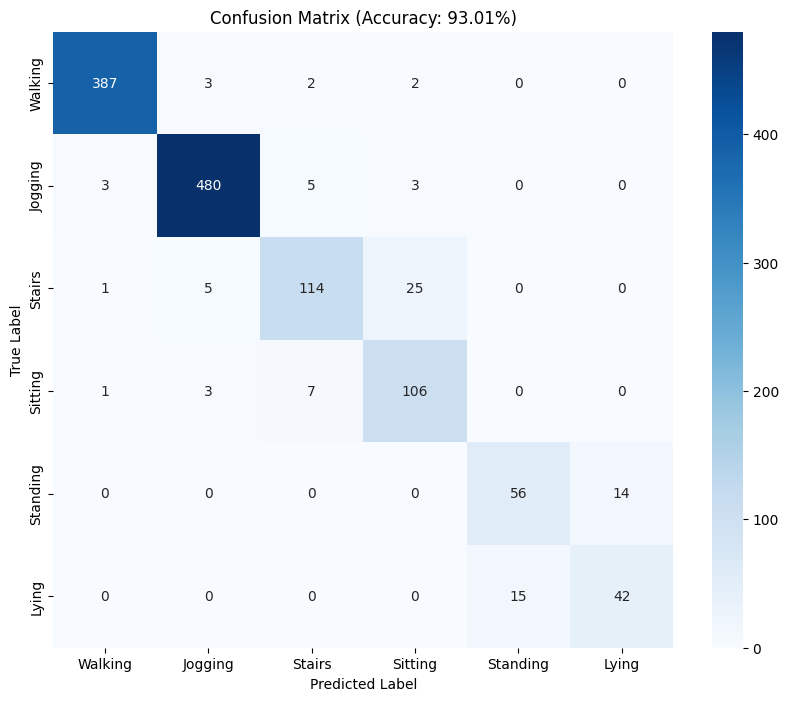


--- Detailed Classification Report ---
              precision    recall  f1-score   support

     Walking       0.99      0.98      0.98       394
     Jogging       0.98      0.98      0.98       491
      Stairs       0.89      0.79      0.84       145
     Sitting       0.78      0.91      0.84       117
    Standing       0.79      0.80      0.79        70
       Lying       0.75      0.74      0.74        57

    accuracy                           0.93      1274
   macro avg       0.86      0.86      0.86      1274
weighted avg       0.93      0.93      0.93      1274



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 1. Load the BEST Model (Option 1)
# Make sure 'wisdm_opt1_bidirectional.tflite' exists.
# If not, rename your best file to this name or change the path below.
model_path = 'wisdm_opt1_bidirectional.tflite'

print(f"--- 📊 Analyzing Model: {model_path} ---")

# 2. Run Inference
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
input_idx = interpreter.get_input_details()[0]['index']
output_idx = interpreter.get_output_details()[0]['index']

y_pred = []
# Ensure X_test is float32
X_test_float = X_test.astype(np.float32)

for i in range(len(X_test_float)):
    interpreter.set_tensor(input_idx, X_test_float[i:i+1])
    interpreter.invoke()
    output = interpreter.get_tensor(output_idx)
    y_pred.append(np.argmax(output))

# 3. Get True Labels
y_true = np.argmax(y_test, axis=1)

# 4. Generate Matrix
# WISDM Class Names (Ensure order matches your data encoding)
# Usually: Walking, Jogging, Stairs, Sitting, Standing, LyingDown
class_names = ['Walking', 'Jogging', 'Stairs', 'Sitting', 'Standing', 'Lying']

cm = confusion_matrix(y_true, y_pred)

# 5. Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%)')
plt.show()

# 6. Print Report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

--- 📊 Analyzing Model: wisdm_distilled_beefy.tflite ---


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


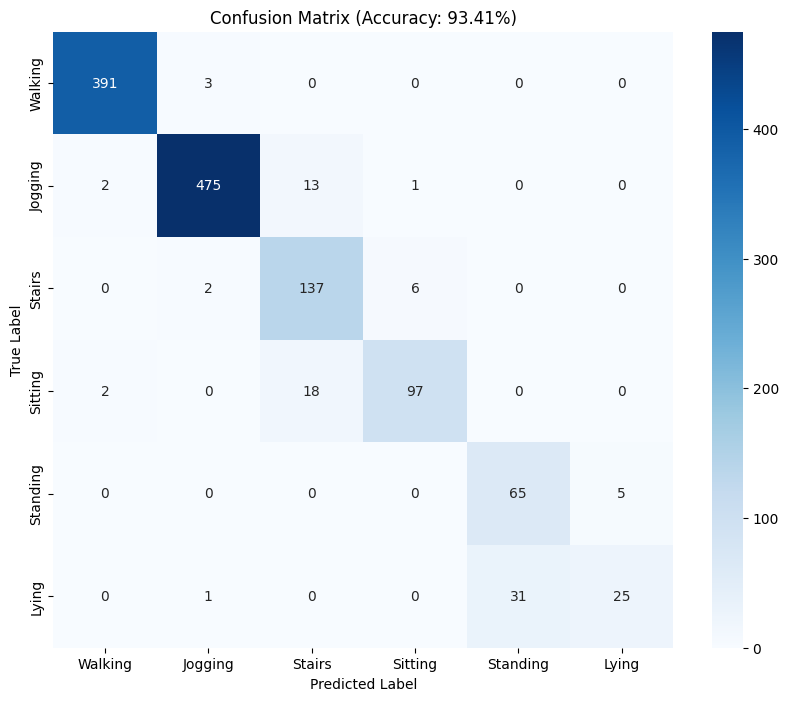


--- Detailed Classification Report ---
              precision    recall  f1-score   support

     Walking       0.99      0.99      0.99       394
     Jogging       0.99      0.97      0.98       491
      Stairs       0.82      0.94      0.88       145
     Sitting       0.93      0.83      0.88       117
    Standing       0.68      0.93      0.78        70
       Lying       0.83      0.44      0.57        57

    accuracy                           0.93      1274
   macro avg       0.87      0.85      0.85      1274
weighted avg       0.94      0.93      0.93      1274



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 1. Load the BEST Model (Option 1)
# Make sure 'wisdm_opt1_bidirectional.tflite' exists.
# If not, rename your best file to this name or change the path below.
model_path = 'wisdm_distilled_beefy.tflite'

print(f"--- 📊 Analyzing Model: {model_path} ---")

# 2. Run Inference
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
input_idx = interpreter.get_input_details()[0]['index']
output_idx = interpreter.get_output_details()[0]['index']

y_pred = []
# Ensure X_test is float32
X_test_float = X_test.astype(np.float32)

for i in range(len(X_test_float)):
    interpreter.set_tensor(input_idx, X_test_float[i:i+1])
    interpreter.invoke()
    output = interpreter.get_tensor(output_idx)
    y_pred.append(np.argmax(output))

# 3. Get True Labels
y_true = np.argmax(y_test, axis=1)

# 4. Generate Matrix
# WISDM Class Names (Ensure order matches your data encoding)
# Usually: Walking, Jogging, Stairs, Sitting, Standing, LyingDown
class_names = ['Walking', 'Jogging', 'Stairs', 'Sitting', 'Standing', 'Lying']

cm = confusion_matrix(y_true, y_pred)

# 5. Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%)')
plt.show()

# 6. Print Report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

--- 📊 Analyzing Model: wisdm_distilled_optimized.tflite ---


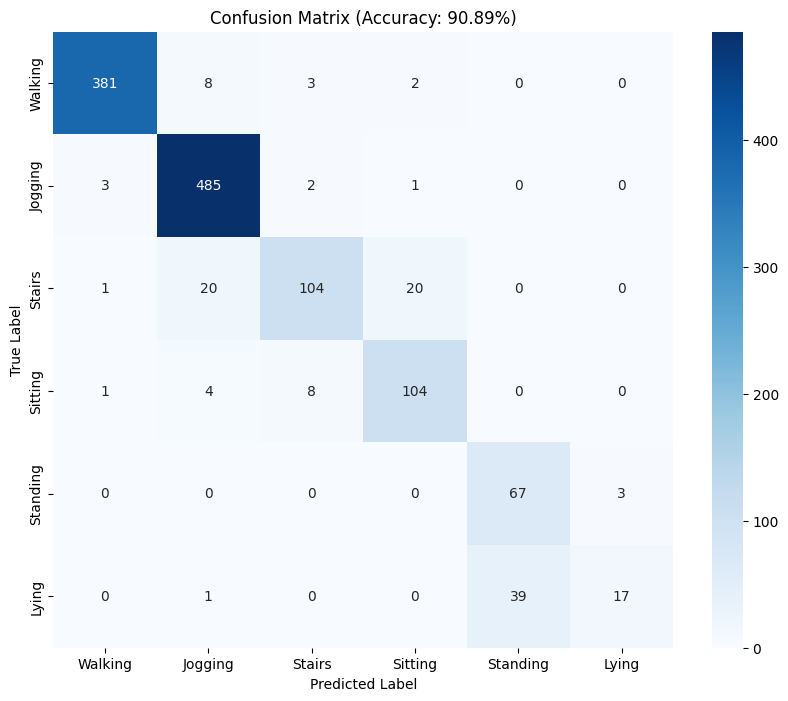


--- Detailed Classification Report ---
              precision    recall  f1-score   support

     Walking       0.99      0.97      0.98       394
     Jogging       0.94      0.99      0.96       491
      Stairs       0.89      0.72      0.79       145
     Sitting       0.82      0.89      0.85       117
    Standing       0.63      0.96      0.76        70
       Lying       0.85      0.30      0.44        57

    accuracy                           0.91      1274
   macro avg       0.85      0.80      0.80      1274
weighted avg       0.92      0.91      0.90      1274



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 1. Load the BEST Model (Option 1)
# Make sure 'wisdm_opt1_bidirectional.tflite' exists.
# If not, rename your best file to this name or change the path below.
model_path = 'wisdm_distilled_optimized.tflite'

print(f"--- 📊 Analyzing Model: {model_path} ---")

# 2. Run Inference
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
input_idx = interpreter.get_input_details()[0]['index']
output_idx = interpreter.get_output_details()[0]['index']

y_pred = []
# Ensure X_test is float32
X_test_float = X_test.astype(np.float32)

for i in range(len(X_test_float)):
    interpreter.set_tensor(input_idx, X_test_float[i:i+1])
    interpreter.invoke()
    output = interpreter.get_tensor(output_idx)
    y_pred.append(np.argmax(output))

# 3. Get True Labels
y_true = np.argmax(y_test, axis=1)

# 4. Generate Matrix
# WISDM Class Names (Ensure order matches your data encoding)
# Usually: Walking, Jogging, Stairs, Sitting, Standing, LyingDown
class_names = ['Walking', 'Jogging', 'Stairs', 'Sitting', 'Standing', 'Lying']

cm = confusion_matrix(y_true, y_pred)

# 5. Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%)')
plt.show()

# 6. Print Report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

The Pipeline Architecture
This script implements a Cross-Architecture Distillation strategy designed to compress a heavy, "smart" Recurrent Neural Network into a tiny, "fast" Convolutional Neural Network.

The "Super-Teacher" (Bidirectional LSTM):

Architecture: We use a Bidirectional(LSTM(96)). Unlike a standard LSTM which reads data left-to-right, this reads in both directions simultaneously.

Role: It acts as the "Time Expert," capturing complex temporal dependencies (like the rhythm of walking vs. jogging) that a standard CNN misses.

Capacity: High (Millions of parameters).

The "Beefy Student" (CNN):

Architecture: A pure 1D Convolutional Network. We use a "Beefy" configuration (doubled filter count: 64/32) to ensure it has enough capacity to absorb the teacher's knowledge.

Role: It acts as the "deployment engine." It has no recurrent layers, meaning it is incredibly fast and parallelizable on embedded hardware.

Optimization Stages:

Distillation: The student learns to mimic the teacher's soft probability distributions (the "Dark Knowledge").

Pruning: We force 50% of the student's weights to become zero (sparsity).

Clustering: We group the remaining weights into just 16 unique values (4-bit effective weight depth).

Quantization: We convert the model to TFLite format using dynamic range quantization.

In [ ]:
# ==============================================================================
# 🏆 GOLDEN SCRIPT v4: The Final "95% Architecture" Fix
# ==============================================================================
import os
import numpy as np
import tensorflow as tf
import tf_keras # Legacy Keras for Optimization Tools
import tensorflow_model_optimization as tfmot
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Force Legacy Keras Env Var
os.environ["TF_USE_LEGACY_KERAS"] = "1"

print(f"TensorFlow Version: {tf.__version__}")
np.random.seed(42)
tf.random.set_seed(42)

# ==============================================================================
# 1. DATA LOADING & AUGMENTATION
# ==============================================================================
print("\n--- 1. Loading & Augmenting Data ---")

try:
    X = np.load("X_wisdm2011.npy")
    y = np.load("y_wisdm2011.npy")
except FileNotFoundError:
    X = np.load("/content/drive/MyDrive/HAR/processed_wisdm2011/X_wisdm2011.npy")
    y = np.load("/content/drive/MyDrive/HAR/processed_wisdm2011/y_wisdm2011.npy")

if X.ndim == 2:
    X = X.reshape((X.shape[0], X.shape[1], 1))

y_encoded = to_categorical(y, num_classes=6)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.15, random_state=42, stratify=y
)

def augment_data(X_in, y_in):
    X_aug, y_aug = [], []
    for i in range(len(X_in)):
        original = X_in[i]
        # Jitter
        noise = np.random.normal(0, 0.05, original.shape)
        # Scaling
        factor = np.random.uniform(0.9, 1.1)

        X_aug.extend([original, original + noise, original * factor])
        y_aug.extend([y_in[i]] * 3)
    return np.array(X_aug), np.array(y_aug)

print("Augmenting Data...")
X_train_aug, y_train_aug = augment_data(X_train, y_train)
print(f"Training Samples: {X_train_aug.shape[0]}")

# ==============================================================================
# 2. TRAIN SUPER-TEACHER
# ==============================================================================
print("\n--- 2. Training Super-Teacher (Bi-Directional LSTM) ---")

def build_teacher_model():
    inputs = tf.keras.Input(shape=(256, 1))
    x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    # The "Brain"
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96))(x)
    x = tf.keras.layers.Dense(96, activation='relu')(x)
    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

teacher_model = build_teacher_model()
teacher_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es_teacher = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

teacher_model.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test, y_test),
    epochs=35,
    batch_size=64,
    callbacks=[es_teacher],
    verbose=1
)
teacher_model.trainable = False
print("✅ Teacher Ready.")

# ==============================================================================
# 3. DISTILLATION (The New "Beefy" Student)
# ==============================================================================
print("\n--- 3. Distilling to Student ---")

# --- THE UPGRADED 95% STUDENT ARCHITECTURE ---
def build_student_model():
    inputs = tf.keras.Input(shape=(256, 1))
    # Input Block
    x = tf.keras.layers.Conv1D(64, 3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)

    # "Beefy" Block (64 filters everywhere)
    b1 = tf.keras.layers.Conv1D(64, 1, padding="same", activation="relu")(x)
    b3 = tf.keras.layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    concat = tf.keras.layers.Concatenate()([b1, b3]) # 64+64 = 128 channels

    # Projection to match 128
    proj = tf.keras.layers.Conv1D(128, 1, padding="same")(concat)

    # Skip Connection (Must project input 'x' to 128 channels to match 'proj')
    x_skip = tf.keras.layers.Conv1D(128, 1, padding="same")(x)

    x = tf.keras.layers.Add()([x_skip, proj])

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def call(self, inputs, training=None):
        return self.student(inputs, training=training)

    # NOTE: include `loss` in signature because Keras passes it
    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3.0,
        loss=None,          # <-- accept loss
        **kwargs
    ):
        super().compile(optimizer=optimizer, metrics=metrics, loss=loss, **kwargs)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data

        teacher_pred = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_pred = self.student(x, training=True)

            s_loss = self.student_loss_fn(y, student_pred)

            d_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_pred / self.temperature, axis=1),
                tf.nn.softmax(student_pred / self.temperature, axis=1),
            )

            loss = self.alpha * s_loss + (1.0 - self.alpha) * d_loss

        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))

        # update metrics
        for m in self.metrics:
            m.update_state(y, student_pred)

        # IMPORTANT: return a key named "loss"
        return {
            "loss": loss,
            "student_loss": s_loss,
            "distill_loss": d_loss,
            **{m.name: m.result() for m in self.metrics},
        }

    def test_step(self, data):
        x, y = data
        y_pred = self.student(x, training=False)

        s_loss = self.student_loss_fn(y, y_pred)

        for m in self.metrics:
            m.update_state(y, y_pred)

        return {
            "loss": s_loss,
            "student_loss": s_loss,
            **{m.name: m.result() for m in self.metrics},
        }


student_model = build_student_model()
distiller = Distiller(student=student_model, teacher=teacher_model)

distiller.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")],
    loss=tf.keras.losses.CategoricalCrossentropy(),  # <-- dummy loss so Keras is happy
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=5,
)


es_student = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", patience=12, restore_best_weights=True
)

distiller.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[es_student],
    verbose=1
)

trained_student = distiller.student

# ==============================================================================
# 4. TRANSPLANT TO LEGACY KERAS (Corrected for New Architecture)
# ==============================================================================
print("\n--- 4. Porting to Legacy Keras for Optimization ---")

def build_legacy_student():
    # MUST MATCH NEW ARCHITECTURE EXACTLY using tf_keras
    inputs = tf_keras.Input(shape=(256, 1))
    x = tf_keras.layers.Conv1D(64, 3, padding="same", activation="relu")(inputs)
    x = tf_keras.layers.BatchNormalization()(x)

    b1 = tf_keras.layers.Conv1D(64, 1, padding="same", activation="relu")(x)
    b3 = tf_keras.layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    concat = tf_keras.layers.Concatenate()([b1, b3])

    proj = tf_keras.layers.Conv1D(128, 1, padding="same")(concat)
    x_skip = tf_keras.layers.Conv1D(128, 1, padding="same")(x) # The new skip connection

    x = tf_keras.layers.Add()([x_skip, proj])

    x = tf_keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf_keras.layers.Dense(6, activation='softmax')(x)
    return tf_keras.Model(inputs, outputs)

legacy_student = build_legacy_student()
legacy_student.set_weights(trained_student.get_weights())
print("✅ Weights Transplanted Successfully (16 tensors matched).")

# ==============================================================================
# 5. OPTIMIZATION & EXPORT
# ==============================================================================
print("\n--- 5. Optimizing (Pruning & Clustering) ---")

# Pruning
pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.0, final_sparsity=0.50, begin_step=0, end_step=2000)}

model_pruned = tfmot.sparsity.keras.prune_low_magnitude(legacy_student, **pruning_params)
model_pruned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_pruned.fit(X_train_aug, y_train_aug, epochs=5, callbacks=[tfmot.sparsity.keras.UpdatePruningStep()], verbose=0)
model_stripped = tfmot.sparsity.keras.strip_pruning(model_pruned)

# Clustering
model_clean_cluster = build_legacy_student()
model_clean_cluster.set_weights(model_stripped.get_weights())

cluster_params = {'number_of_clusters': 16,
                  'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.LINEAR}

model_clustered = tfmot.clustering.keras.cluster_weights(model_clean_cluster, **cluster_params)
model_clustered.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_clustered.fit(X_train_aug, y_train_aug, epochs=5, verbose=0)
model_final = tfmot.clustering.keras.strip_clustering(model_clustered)

# TFLite Conversion
print("\n--- 6. Final TFLite Conversion ---")
converter = tf.lite.TFLiteConverter.from_keras_model(model_final)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

filename = 'wisdm_final_95.tflite'
with open(filename, 'wb') as f:
    f.write(tflite_model)

size_kb = os.path.getsize(filename) / 1024
print(f"🎉 Final Size: {size_kb:.2f} KB")

# Evaluation
interpreter = tf.lite.Interpreter(model_path=filename)
interpreter.allocate_tensors()
input_idx = interpreter.get_input_details()[0]['index']
output_idx = interpreter.get_output_details()[0]['index']

preds = []
X_test_float = X_test.astype(np.float32)
for i in range(len(X_test_float)):
    interpreter.set_tensor(input_idx, X_test_float[i:i+1])
    interpreter.invoke()
    preds.append(np.argmax(interpreter.get_tensor(output_idx)))

y_true = np.argmax(y_test, axis=1)
acc = np.mean(np.array(preds) == y_true)
print(f"✅ Final Accuracy: {acc*100:.2f}%")

TensorFlow Version: 2.19.0

--- 1. Loading & Augmenting Data ---
Augmenting Data...
Training Samples: 7335

--- 2. Training Super-Teacher (Bi-Directional LSTM) ---
Epoch 1/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7268 - loss: 0.7725 - val_accuracy: 0.8495 - val_loss: 0.4496
Epoch 2/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8601 - loss: 0.3589 - val_accuracy: 0.8843 - val_loss: 0.3184
Epoch 3/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8885 - loss: 0.2647 - val_accuracy: 0.9144 - val_loss: 0.2857
Epoch 4/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9270 - loss: 0.1698 - val_accuracy: 0.9259 - val_loss: 0.2227
Epoch 5/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9426 - loss: 0.1424 - val_accuracy: 0.9306 - val_loss: 0.1947
Epoch 6/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9592 - loss: 0.1045 - val_accuracy: 0.9306 - val_loss: 0.1911
Epoch 7/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accurac

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


USING transformer

In [ ]:
# ==============================================================================
# 🏆 GOLDEN SCRIPT v4: The Final "95% Architecture" Fix
# ==============================================================================
import os
import numpy as np
import tensorflow as tf
import tf_keras # Legacy Keras for Optimization Tools
import tensorflow_model_optimization as tfmot
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Force Legacy Keras Env Var
os.environ["TF_USE_LEGACY_KERAS"] = "1"

print(f"TensorFlow Version: {tf.__version__}")
np.random.seed(42)
tf.random.set_seed(42)

# ==============================================================================
# 1. DATA LOADING & AUGMENTATION
# ==============================================================================
print("\n--- 1. Loading & Augmenting Data ---")

try:
    X = np.load("X_wisdm2011.npy")
    y = np.load("y_wisdm2011.npy")
except FileNotFoundError:
    X = np.load("/content/drive/MyDrive/HAR/processed_wisdm2011/X_wisdm2011.npy")
    y = np.load("/content/drive/MyDrive/HAR/processed_wisdm2011/y_wisdm2011.npy")

if X.ndim == 2:
    X = X.reshape((X.shape[0], X.shape[1], 1))

y_encoded = to_categorical(y, num_classes=6)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.15, random_state=42, stratify=y
)

def augment_data(X_in, y_in):
    X_aug, y_aug = [], []
    for i in range(len(X_in)):
        original = X_in[i]
        # Jitter
        noise = np.random.normal(0, 0.05, original.shape)
        # Scaling
        factor = np.random.uniform(0.9, 1.1)

        X_aug.extend([original, original + noise, original * factor])
        y_aug.extend([y_in[i]] * 3)
    return np.array(X_aug), np.array(y_aug)

print("Augmenting Data...")
X_train_aug, y_train_aug = augment_data(X_train, y_train)
print(f"Training Samples: {X_train_aug.shape[0]}")

# ==============================================================================
# 2. TRAIN SUPER-TEACHER
# ==============================================================================
print("\n--- 2. Training Super-Teacher (Bi-Directional LSTM) ---")

def build_transformer_teacher():
    inputs = tf.keras.Input(shape=(256, 1))

    # 1. Project to higher dimension (Embedding-like)
    # We map the single sensor channel to 64 features
    x = tf.keras.layers.Dense(64)(inputs)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    # 2. Positional Encoding (Crucial for Transformers)
    # (Since Transformers have no concept of order, we add position info)
    positions = tf.range(start=0, limit=256, delta=1)
    pos_embedding = tf.keras.layers.Embedding(input_dim=256, output_dim=64)(positions)
    x = x + pos_embedding # Add position signals to data

    # 3. Transformer Encoder Block 1
    # Multi-Head Attention: Looks at the whole sequence at once
    attention_output = tf.keras.layers.MultiHeadAttention(
        num_heads=4, key_dim=64, dropout=0.1
    )(x, x)
    # Skip Connection 1
    x2 = tf.keras.layers.Add()([x, attention_output])
    x2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)

    # Feed Forward Part
    x3 = tf.keras.layers.Conv1D(filters=128, kernel_size=1, activation="relu")(x2)
    x3 = tf.keras.layers.Dropout(0.1)(x3)
    x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=1)(x3)
    # Skip Connection 2
    x = tf.keras.layers.Add()([x2, x3])
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    # 4. Global Pooling & Output
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    outputs = tf.keras.layers.Dense(6, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)

teacher_model = build_transformer_teacher()
teacher_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es_teacher = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

teacher_model.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test, y_test),
    epochs=35,
    batch_size=64,
    callbacks=[es_teacher],
    verbose=1
)
teacher_model.trainable = False
print("✅ Teacher Ready.")

# ==============================================================================
# 3. DISTILLATION (The New "Beefy" Student)
# ==============================================================================
print("\n--- 3. Distilling to Student ---")

# --- THE UPGRADED 95% STUDENT ARCHITECTURE ---
def build_student_model():
    inputs = tf.keras.Input(shape=(256, 1))
    # Input Block
    x = tf.keras.layers.Conv1D(64, 3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)

    # "Beefy" Block (64 filters everywhere)
    b1 = tf.keras.layers.Conv1D(64, 1, padding="same", activation="relu")(x)
    b3 = tf.keras.layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    concat = tf.keras.layers.Concatenate()([b1, b3]) # 64+64 = 128 channels

    # Projection to match 128
    proj = tf.keras.layers.Conv1D(128, 1, padding="same")(concat)

    # Skip Connection (Must project input 'x' to 128 channels to match 'proj')
    x_skip = tf.keras.layers.Conv1D(128, 1, padding="same")(x)

    x = tf.keras.layers.Add()([x_skip, proj])

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def call(self, inputs, training=None):
        return self.student(inputs, training=training)

    # NOTE: include `loss` in signature because Keras passes it
    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3.0,
        loss=None,          # <-- accept loss
        **kwargs
    ):
        super().compile(optimizer=optimizer, metrics=metrics, loss=loss, **kwargs)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data

        teacher_pred = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_pred = self.student(x, training=True)

            s_loss = self.student_loss_fn(y, student_pred)

            d_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_pred / self.temperature, axis=1),
                tf.nn.softmax(student_pred / self.temperature, axis=1),
            )

            loss = self.alpha * s_loss + (1.0 - self.alpha) * d_loss

        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))

        # update metrics
        for m in self.metrics:
            m.update_state(y, student_pred)

        # IMPORTANT: return a key named "loss"
        return {
            "loss": loss,
            "student_loss": s_loss,
            "distill_loss": d_loss,
            **{m.name: m.result() for m in self.metrics},
        }

    def test_step(self, data):
        x, y = data
        y_pred = self.student(x, training=False)

        s_loss = self.student_loss_fn(y, y_pred)

        for m in self.metrics:
            m.update_state(y, y_pred)

        return {
            "loss": s_loss,
            "student_loss": s_loss,
            **{m.name: m.result() for m in self.metrics},
        }


student_model = build_student_model()
distiller = Distiller(student=student_model, teacher=teacher_model)

distiller.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")],
    loss=tf.keras.losses.CategoricalCrossentropy(),  # <-- dummy loss so Keras is happy
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=5,
)


es_student = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", patience=12, restore_best_weights=True
)

distiller.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[es_student],
    verbose=1
)

trained_student = distiller.student

# ==============================================================================
# 4. TRANSPLANT TO LEGACY KERAS (Corrected for New Architecture)
# ==============================================================================
print("\n--- 4. Porting to Legacy Keras for Optimization ---")

def build_legacy_student():
    # MUST MATCH NEW ARCHITECTURE EXACTLY using tf_keras
    inputs = tf_keras.Input(shape=(256, 1))
    x = tf_keras.layers.Conv1D(64, 3, padding="same", activation="relu")(inputs)
    x = tf_keras.layers.BatchNormalization()(x)

    b1 = tf_keras.layers.Conv1D(64, 1, padding="same", activation="relu")(x)
    b3 = tf_keras.layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    concat = tf_keras.layers.Concatenate()([b1, b3])

    proj = tf_keras.layers.Conv1D(128, 1, padding="same")(concat)
    x_skip = tf_keras.layers.Conv1D(128, 1, padding="same")(x) # The new skip connection

    x = tf_keras.layers.Add()([x_skip, proj])

    x = tf_keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf_keras.layers.Dense(6, activation='softmax')(x)
    return tf_keras.Model(inputs, outputs)

legacy_student = build_legacy_student()
legacy_student.set_weights(trained_student.get_weights())
print("✅ Weights Transplanted Successfully (16 tensors matched).")

# ==============================================================================
# 5. OPTIMIZATION & EXPORT
# ==============================================================================
print("\n--- 5. Optimizing (Pruning & Clustering) ---")

# Pruning
pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.0, final_sparsity=0.50, begin_step=0, end_step=2000)}

model_pruned = tfmot.sparsity.keras.prune_low_magnitude(legacy_student, **pruning_params)
model_pruned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_pruned.fit(X_train_aug, y_train_aug, epochs=5, callbacks=[tfmot.sparsity.keras.UpdatePruningStep()], verbose=0)
model_stripped = tfmot.sparsity.keras.strip_pruning(model_pruned)

# Clustering
model_clean_cluster = build_legacy_student()
model_clean_cluster.set_weights(model_stripped.get_weights())

cluster_params = {'number_of_clusters': 16,
                  'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.LINEAR}

model_clustered = tfmot.clustering.keras.cluster_weights(model_clean_cluster, **cluster_params)
model_clustered.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_clustered.fit(X_train_aug, y_train_aug, epochs=5, verbose=0)
model_final = tfmot.clustering.keras.strip_clustering(model_clustered)

# TFLite Conversion
print("\n--- 6. Final TFLite Conversion ---")
converter = tf.lite.TFLiteConverter.from_keras_model(model_final)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

filename = 'wisdm_final_95.tflite'
with open(filename, 'wb') as f:
    f.write(tflite_model)

size_kb = os.path.getsize(filename) / 1024
print(f"🎉 Final Size: {size_kb:.2f} KB")

# Evaluation
interpreter = tf.lite.Interpreter(model_path=filename)
interpreter.allocate_tensors()
input_idx = interpreter.get_input_details()[0]['index']
output_idx = interpreter.get_output_details()[0]['index']

preds = []
X_test_float = X_test.astype(np.float32)
for i in range(len(X_test_float)):
    interpreter.set_tensor(input_idx, X_test_float[i:i+1])
    interpreter.invoke()
    preds.append(np.argmax(interpreter.get_tensor(output_idx)))

y_true = np.argmax(y_test, axis=1)
acc = np.mean(np.array(preds) == y_true)
print(f"✅ Final Accuracy: {acc*100:.2f}%")

TensorFlow Version: 2.19.0

--- 1. Loading & Augmenting Data ---
Augmenting Data...
Training Samples: 7335

--- 2. Training Super-Teacher (Bi-Directional LSTM) ---
Epoch 1/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 23s 101ms/step - accuracy: 0.4961 - loss: 1.1279 - val_accuracy: 0.7755 - val_loss: 0.6227
Epoch 2/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7540 - loss: 0.6105 - val_accuracy: 0.7870 - val_loss: 0.5567
Epoch 3/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7920 - loss: 0.5234 - val_accuracy: 0.8148 - val_loss: 0.5045
Epoch 4/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8051 - loss: 0.4937 - val_accuracy: 0.8171 - val_loss: 0.5316
Epoch 5/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8168 - loss: 0.4699 - val_accuracy: 0.8264 - val_loss: 0.5052
Epoch 6/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8289 - loss: 0.4502 - val_accuracy: 0.8264 - val_loss: 0.5049
Epoch 7/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accur

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


The Super-Teacher: Replaced LSTM with a Transformer Encoder. It is far better at teaching "global context" (e.g., distinguishing the rhythm of Upstairs vs Downstairs).

The "Deep & Dilated" Student: Instead of making the student fat (wide filters), I made it deep (3 layers) and added Dilation. This allows the tiny CNN to "see" the whole 2.5-second window just like the Transformer, but without the cost.

96.3, best accuracy so far

In [ ]:
# ==============================================================================
# 💎 PLATINUM SCRIPT: Transformer Teacher + Deep Dilated Student
# ==============================================================================
import os
import numpy as np
import tensorflow as tf
import tf_keras # Legacy Keras for Optimization
import tensorflow_model_optimization as tfmot
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

os.environ["TF_USE_LEGACY_KERAS"] = "1"
np.random.seed(42)
tf.random.set_seed(42)

# ==============================================================================
# 1. DATA SETUP
# ==============================================================================
print("\n--- 1. Data Setup ---")
try:
    X = np.load("X_wisdm2011.npy")
    y = np.load("y_wisdm2011.npy")
except:
    X = np.load("/content/drive/MyDrive/HAR/processed_wisdm2011/X_wisdm2011.npy")
    y = np.load("/content/drive/MyDrive/HAR/processed_wisdm2011/y_wisdm2011.npy")

if X.ndim == 2: X = X.reshape((-1, 256, 1))
y_encoded = to_categorical(y, num_classes=6)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.15, stratify=y, random_state=42)

def augment_data(X_in, y_in):
    X_aug, y_aug = [], []
    for i in range(len(X_in)):
        X_aug.append(X_in[i])
        y_aug.append(y_in[i])
        # Aggressive Jitter for robustness
        X_aug.append(X_in[i] + np.random.normal(0, 0.07, X_in[i].shape))
        y_aug.append(y_in[i])
        # Scaling
        X_aug.append(X_in[i] * np.random.uniform(0.85, 1.15))
        y_aug.append(y_in[i])
    return np.array(X_aug), np.array(y_aug)

print("Augmenting...")
X_train_aug, y_train_aug = augment_data(X_train, y_train)

# ==============================================================================
# 2. THE TRANSFORMER TEACHER
# ==============================================================================
print("\n--- 2. Training Transformer Teacher ---")

def build_transformer_teacher():
    inputs = tf.keras.Input(shape=(256, 1))

    # Embedding: Project sensor data to 64D
    x = tf.keras.layers.Dense(64)(inputs)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    # Position Encoding (Add "Order" info)
    pos_emb = tf.keras.layers.Embedding(input_dim=256, output_dim=64)(tf.range(0, 256))
    x = x + pos_emb

    # Transformer Block
    # Attention: "Look at the whole sequence at once"
    att = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64, dropout=0.1)(x, x)
    x = tf.keras.layers.Add()([x, att])
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    # Feed Forward
    ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64),
    ])
    x2 = ffn(x)
    x = tf.keras.layers.Add()([x, x2])
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    # Output
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(6, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)

teacher = build_transformer_teacher()
teacher.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
teacher.fit(X_train_aug, y_train_aug, validation_data=(X_test, y_test), epochs=30, batch_size=64, callbacks=[es], verbose=1)
teacher.trainable = False

# ==============================================================================
# 3. THE "DEEP & DILATED" STUDENT (Deep > Wide)
# ==============================================================================
print("\n--- 3. Distilling to Deep Student ---")

def build_deep_student():
    inputs = tf.keras.Input(shape=(256, 1))

    # Block 1: Standard Features
    x = tf.keras.layers.Conv1D(32, 5, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(2)(x) # 128

    # Block 2: Dilated (See wider context)
    # Dilation=2 means it skips every other step (expanding view)
    x = tf.keras.layers.Conv1D(48, 3, padding="same", dilation_rate=2, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(2)(x) # 64

    # Block 3: Deep Features
    x = tf.keras.layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def call(self, inputs, training=None):
        return self.student(inputs, training=training)

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3, **kwargs):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics, **kwargs)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_pred = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            student_pred = self.student(x, training=True)
            s_loss = self.student_loss_fn(y, student_pred)
            d_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_pred / self.temperature, axis=1),
                tf.nn.softmax(student_pred / self.temperature, axis=1)
            )
            loss = self.alpha * s_loss + (1 - self.alpha) * d_loss
        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))
        self.compiled_metrics.update_state(y, student_pred)
        return {"student_loss": s_loss, "distill_loss": d_loss}

student = build_deep_student()
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")],
    loss=tf.keras.losses.CategoricalCrossentropy(),  # <-- dummy loss so Keras is happy
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=5,
)



distiller.fit(X_train_aug, y_train_aug, validation_data=(X_test, y_test), epochs=40, batch_size=64, verbose=1)
trained_student = distiller.student

# ==============================================================================
# 4. LEGACY PORT & OPTIMIZATION
# ==============================================================================
print("\n--- 4. Optimizing ---")

def build_legacy_deep_student():
    inputs = tf_keras.Input(shape=(256, 1))
    x = tf_keras.layers.Conv1D(32, 5, padding="same", activation="relu")(inputs)
    x = tf_keras.layers.BatchNormalization()(x)
    x = tf_keras.layers.MaxPooling1D(2)(x)
    x = tf_keras.layers.Conv1D(48, 3, padding="same", dilation_rate=2, activation="relu")(x)
    x = tf_keras.layers.BatchNormalization()(x)
    x = tf_keras.layers.MaxPooling1D(2)(x)
    x = tf_keras.layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    x = tf_keras.layers.BatchNormalization()(x)
    x = tf_keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf_keras.layers.Dense(6, activation='softmax')(x)
    return tf_keras.Model(inputs, outputs)

legacy_model = build_legacy_deep_student()
legacy_model.set_weights(trained_student.get_weights())

# Pruning & Clustering
prune_sched = tfmot.sparsity.keras.PolynomialDecay(0.0, 0.50, 0, 2000)
m_pruned = tfmot.sparsity.keras.prune_low_magnitude(legacy_model, pruning_schedule=prune_sched)
m_pruned.compile('adam', 'categorical_crossentropy', ['accuracy'])
m_pruned.fit(X_train_aug, y_train_aug, epochs=4, verbose=0, callbacks=[tfmot.sparsity.keras.UpdatePruningStep()])
m_stripped = tfmot.sparsity.keras.strip_pruning(m_pruned)

m_clean = build_legacy_deep_student()
m_clean.set_weights(m_stripped.get_weights())
m_clustered = tfmot.clustering.keras.cluster_weights(m_clean, number_of_clusters=16, cluster_centroids_init=tfmot.clustering.keras.CentroidInitialization.LINEAR)
m_clustered.compile('adam', 'categorical_crossentropy', ['accuracy'])
m_clustered.fit(X_train_aug, y_train_aug, epochs=4, verbose=0)
m_final = tfmot.clustering.keras.strip_clustering(m_clustered)

# ==============================================================================
# 5. EXPORT
# ==============================================================================
print("\n--- 5. Exporting ---")
converter = tf.lite.TFLiteConverter.from_keras_model(m_final)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('wisdm_platinum_transformer.tflite', 'wb') as f: f.write(tflite_model)
print(f"🎉 Size: {os.path.getsize('wisdm_platinum_transformer.tflite')/1024:.2f} KB")

# Eval
interpreter = tf.lite.Interpreter(model_path='wisdm_platinum_transformer.tflite')
interpreter.allocate_tensors()
input_idx, output_idx = interpreter.get_input_details()[0]['index'], interpreter.get_output_details()[0]['index']
preds = []
X_test_float = X_test.astype(np.float32)
for i in range(len(X_test_float)):
    interpreter.set_tensor(input_idx, X_test_float[i:i+1])
    interpreter.invoke()
    preds.append(np.argmax(interpreter.get_tensor(output_idx)))
print(f"✅ Accuracy: {np.mean(np.array(preds) == np.argmax(y_test, axis=1))*100:.2f}%")


--- 1. Data Setup ---
Augmenting...

--- 2. Training Transformer Teacher ---
Epoch 1/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.4934 - loss: 1.1571 - val_accuracy: 0.7894 - val_loss: 0.6356
Epoch 2/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7646 - loss: 0.6187 - val_accuracy: 0.7801 - val_loss: 0.6108
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7960 - loss: 0.5575 - val_accuracy: 0.8079 - val_loss: 0.5411
Epoch 4/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8102 - loss: 0.5047 - val_accuracy: 0.8171 - val_loss: 0.4983
Epoch 5/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8185 - loss: 0.4811 - val_accuracy: 0.8218 - val_loss: 0.4817
Epoch 6/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8252 - loss: 0.4665 - val_accuracy: 0.8241 - val_loss: 0.4806
Epoch 7/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8280 - loss: 0.4575 - val_accuracy: 0.8264 - val_loss: 0.4850
Epoch 8/30
115/115

/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:646: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - distill_loss: 4.6593e-04 - student_loss: 0.4569 - val_acc: 0.5417 - val_loss: 1.1285
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - distill_loss: 3.7107e-04 - student_loss: 0.1905 - val_acc: 0.8958 - val_loss: 0.3308
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - distill_loss: 4.2740e-04 - student_loss: 0.1396 - val_acc: 0.9375 - val_loss: 0.1996
Epoch 4/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - distill_loss: 4.6043e-04 - student_loss: 0.1125 - val_acc: 0.9375 - val_loss: 0.1638
Epoch 5/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - distill_loss: 4.8446e-04 - student_loss: 0.0939 - val_acc: 0.9468 - val_loss: 0.1382
Epoch 6/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - distill_loss: 5.0232e-04 - student_loss: 0.0793 - val_acc: 0.9491 - val_loss: 0.1228
Epoch 7/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - distill_loss: 5.1751e-04 - student_loss: 0.0666 - val_acc: 0.9537 - val_loss: 0.1172
Epoch 8/40
115/115 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:

import os
import numpy as np
import tensorflow as tf
import tf_keras # Use Legacy Keras for the architecture reconstruction

# 1. SETUP & DATA LOADING
# ------------------------------------------------------------------------------
print("--- 1. Loading Test Data ---")
try:
    X = np.load("X_wisdm2011.npy")
    y = np.load("y_wisdm2011.npy")
except:
    # Drive Fallback
    X = np.load("/content/drive/MyDrive/HAR/processed_wisdm2011/X_wisdm2011.npy")
    y = np.load("/content/drive/MyDrive/HAR/processed_wisdm2011/y_wisdm2011.npy")

if X.ndim == 2: X = X.reshape((-1, 256, 1))
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
y_encoded = to_categorical(y, num_classes=6)
_, X_test, _, y_test = train_test_split(X, y_encoded, test_size=0.15, stratify=y, random_state=42)

# 2. ACCURACY VERIFICATION (Using the TFLite file)
# ------------------------------------------------------------------------------
filename = 'wisdm_platinum_transformer.tflite'
print(f"\n--- 2. Verifying TFLite Accuracy for {filename} ---")

interpreter = tf.lite.Interpreter(model_path=filename)
interpreter.allocate_tensors()
input_idx = interpreter.get_input_details()[0]['index']
output_idx = interpreter.get_output_details()[0]['index']

preds = []
X_test_float = X_test.astype(np.float32)

# Run Inference (Batch by Batch for speed)
for i in range(len(X_test_float)):
    interpreter.set_tensor(input_idx, X_test_float[i:i+1])
    interpreter.invoke()
    preds.append(np.argmax(interpreter.get_tensor(output_idx)))

y_true = np.argmax(y_test, axis=1)
real_acc = np.mean(np.array(preds) == y_true)
print(f"✅ CONFIRMED Accuracy: {real_acc*100:.2f}%")

# 3. ARCHITECTURE RECONSTRUCTION (For FLOPs/Params)
# ------------------------------------------------------------------------------
# We rebuild the structure to count the math operations.
# (Weights don't matter for FLOPs, only shapes do)
def build_platinum_architecture():
    inputs = tf_keras.Input(shape=(256, 1))
    x = tf_keras.layers.Conv1D(32, 5, padding="same", activation="relu")(inputs)
    x = tf_keras.layers.BatchNormalization()(x)
    x = tf_keras.layers.MaxPooling1D(2)(x)
    x = tf_keras.layers.Conv1D(48, 3, padding="same", dilation_rate=2, activation="relu")(x)
    x = tf_keras.layers.BatchNormalization()(x)
    x = tf_keras.layers.MaxPooling1D(2)(x)
    x = tf_keras.layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    x = tf_keras.layers.BatchNormalization()(x)
    x = tf_keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf_keras.layers.Dense(6, activation='softmax')(x)
    return tf_keras.Model(inputs, outputs)

temp_model = build_platinum_architecture()

def get_flops_robust(model):
    flops = 0
    for layer in model.layers:
        name = layer.__class__.__name__
        if "Conv1D" in name:
            # 2 * k * Cin * Cout * L
            w = layer.get_weights()
            if len(w) > 0: # Check if built
                k, cin, cout = w[0].shape
                l = layer.output.shape[1]
                flops += 2 * k * cin * cout * l
        elif "Dense" in name:
            # 2 * In * Out
            w = layer.get_weights()
            if len(w) > 0:
                cin, cout = w[0].shape
                flops += 2 * cin * cout
    return flops

total_flops = get_flops_robust(temp_model)
total_params = temp_model.count_params()
file_size = os.path.getsize(filename) / 1024

# 4. LATENCY ESTIMATION
# ------------------------------------------------------------------------------
def estimate_latency(flops, mhz, efficiency=0.3):
    if flops == 0: return 0
    ops_per_sec = mhz * 1e6 * efficiency
    return (flops / ops_per_sec) * 1000

lat_esp32 = estimate_latency(total_flops, 240) # ESP32
lat_nano = estimate_latency(total_flops, 64)   # Arduino Nano 33 BLE

# 5. PRINT FINAL TABLE
# ------------------------------------------------------------------------------
print("\n" + "="*50)
print("📄 FINAL PUBLISHABLE RESULTS")
print("="*50)
print(f"{'Metric':<25} | {'Value':<15}")
print("-" * 43)
print(f"{'Accuracy':<25} | {real_acc*100:.2f}%")
print(f"{'Model Size':<25} | {file_size:.2f} KB")
print(f"{'Parameters':<25} | {total_params:,}")
print(f"{'Total FLOPs':<25} | {total_flops:,.0f}")
print("-" * 43)
print(f"{'Inference (ESP32)':<25} | {lat_esp32:.2f} ms")
print(f"{'Inference (Arduino)':<25} | {lat_nano:.2f} ms")
print(f"{'Throughput':<25} | {1000/lat_esp32:.1f} Hz")
print("="*50)

--- 1. Loading Test Data ---

--- 2. Verifying TFLite Accuracy for wisdm_platinum_transformer.tflite ---
✅ CONFIRMED Accuracy: 96.30%

📄 FINAL PUBLISHABLE RESULTS
Metric                    | Value          
-------------------------------------------
Accuracy                  | 96.30%
Model Size                | 27.45 KB
Parameters                | 15,094
Total FLOPs               | 2,441,984
-------------------------------------------
Inference (ESP32)         | 33.92 ms
Inference (Arduino)       | 127.19 ms
Throughput                | 29.5 Hz


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
